In [1]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Functions used in this code
import age_functions as afunc

### Geometry
import lmcgeometry as lgeo

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [2]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)
    
# def age_model(x1,x2,x3):  
#     #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
#     p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
#          1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]
#     age = (p[0]+p[1]*x1+p[2]*x2+p[3]*x3+
#            p[4]*np.multiply(x1,x2)+p[5]*np.multiply(x1,x3)+p[6]*np.multiply(x2,x3)+
#            p[7]*(x1**2)+p[8]*(x2**2)+p[9]*(x3**2)+
#            p[10]*(x2**3)+p[11]*(x3**3))
    
#     return age

def age_model(z1,z2,z3):
    #x1,x2,x3,x12,x13,x23,x1sq,x2sq,x3sq,x2cu,x3cu
#     p = [9.80896282e+00,-4.65080541e-03,2.72682487e-02,-3.23531502e+00,2.22256767e-02,4.53706896e-02,
#          -8.80208834e-02,-7.28411958e-03,3.80042306e-02,8.48943269e-01,-3.56646067e-02,2.32900165e-02]
#     p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
#          1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]

    p = [9.80896282e+00,-4.65080541e-03,2.72682487e-02,-3.23531502e+00,2.22256767e-02,4.53706896e-02,
         -8.80208834e-02,-7.28411958e-03,3.80042306e-02,8.48943269e-01,-3.56646067e-02,2.32900165e-02]
    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    return age
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [3]:
################
### LMC Data ###
################

### Import Data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.r13-l33-58672.fits.gz',1)
cln = np.where((lmc['FE_H']>-9999.0)&(lmc['AK_TARG']>-9999.0)&(lmc['LOGG']>0.0)&(lmc['M_H_ERR']>-90.0)&
                (lmc['C_FE']>-9999.0)&(lmc['N_FE']>-9999.0))

lmc = lmc[cln]

gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = gcs[cln]

elems = ['M_H','C_FE','N_FE','O_FE','NA_FE','MG_FE','AL_FE','SI_FE','P_FE','S_FE','K_FE','CA_FE','TI_FE',
         'TIII_FE','V_FE','CR_FE','MN_FE','FE_H','CO_FE','NI_FE','CU_FE','GE_FE','RB_FE','CE_FE','ND_FE','YB_FE']

labs = ['[M_H]','[C/Fe]','[N/Fe]','[O/Fe]','[Na/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[P/Fe]','[S/Fe]','[K/Fe]',
        '[Ca/Fe]','[Ti/Fe]','[TiII/Fe]','[V/Fe]','[Cr/Fe]','[Mn/Fe]','[Fe/H]','[Co/Fe]','[Ni/Fe]','[Cu/Fe]',
        '[Ge/Fe]','[Rb/Fe]','[Ce/Fe]','[Nd/Fe]','[Yb/Fe]']

### LMC Geometry
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = lgeo.elliptical_radius(x,y)

### PARSEC
# parsecall = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic', delimiter='\s')

# rgb = np.where(parsecall['label']==3)
# parsec = parsecall[rgb]

# # linAge: 0.5e9 - 7.0e9, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
# young_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_0.5_7.0.dat',format='basic',
#                           delimiter='\s')
# # linAge: 7.5e9 - 1.4e10, 0.5e9; MH: -2.6 - 0.1, 0.1 '''Only goes to -2.2; Only 7 LMC less than -2.2'''
# old_parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3.4_7.5_14.0.dat',format='basic',
#                           delimiter='\s')

# parsec = vstack([young_parsec,old_parsec])

# rgb = np.where(parsec['label']==3)
# parsec = parsec[rgb]

parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

### GC cluster tables
'''
The ACS survey of Galactic globular clusters – XIV. Bayesian single-population analysis of 69 globular clusters
Wagner-Kaiser et al. 2017
'''
import pandas as pd
supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp3 = pd.read_csv('../stx544_Supp/Table3.txt',comment='#',
                    names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',
                           'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',
                           'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',
                           'RelativeAge'],sep='\s+')

-2.1930616

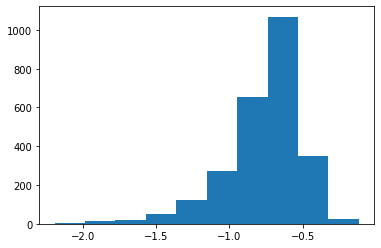

In [4]:
plt.hist(lmc['FE_H'])
min(lmc['FE_H'])

In [5]:
ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['Cluster'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M3: NGC5272
    elif (gcs['Cluster'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['Cluster'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['Cluster'][i]=='M5'): 
        ngc_names.append('NGC5904')
    
    #M10: NGC6254
    elif (gcs['Cluster'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M12: NGC6218
    elif (gcs['Cluster'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['Cluster'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15: NGC7078
    elif (gcs['Cluster'][i]=='M15'): 
        ngc_names.append('NGC7078')
    
    #M19: NGC6273
    elif (gcs['Cluster'][i]=='M19'): 
        ngc_names.append('NGC6273')
    
    #M22: NGC6656
    elif (gcs['Cluster'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M53: NGC5024
    elif (gcs['Cluster'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M54: NGC6715
    elif (gcs['Cluster'][i]=='M54'): 
        ngc_names.append('NGC6715')
    
    #M55: NGC6809
    elif (gcs['Cluster'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68: NGC4590
    elif (gcs['Cluster'][i]=='M68'): 
        ngc_names.append('NGC4590')   
    
    #M71: NGC6838
    elif (gcs['Cluster'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['Cluster'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92: NGC6341
    elif (gcs['Cluster'][i]=='M92'): 
        ngc_names.append('NGC5904')
    
    #M107: NGC6171
    elif (gcs['Cluster'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #omegaCen: NGC5139
    elif (gcs['Cluster'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['Cluster'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

In [6]:
apogee_clus_idx = []
apogee_clus_idx2 = []

for i in supp2['Cluster'][s2_ind]:
    apogee_clus_idx.append(np.where(ngc_names==i))
    apogee_clus_idx2.append(np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))]==i))
    

In [7]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

In [8]:
def absmag(magnitude,distance):
    '''
    - magnitude: apparent magnitude of star
    - distance: distance to star in kpc
    Calculate the absolute magnitude of star
    '''
    absm = []
    absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
    absm = np.squeeze(np.array(absm))
    return absm

_,_, ldist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])

lmc_ksmag = absmag(lmc['K'],ldist)
gcs_ksmag = absmag(gcs['K'],gcs['distmed'])

In [9]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

# gcs2 = gcs[np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))]

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = gcs['distmed'][i]
    dist_err = gcs['sigma_dist'][i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = add_noise(dist,dist_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,am_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
devs = np.asarray(devs)
parages = np.asarray(parages)

In [12]:
np.where(ngc_names=='NGC4147')

(array([366]),)

In [24]:
np.median(4.0)

4.0

In [21]:
clus_ages = [-9999.0,-9999.0,14.46,13.06,10.62,10.37,10.24,-9999.0,-9999.0,-9999.0,10.24,-9999.0,-9999.0,12.54,
             12.67,12.29,11.52,11.39,12.54,13.57,10.62,12.67,12.16,12.54,12.54,12.52,13.82,13.95,11.65,12.67,
             11.39,13.57,13.18,12.67,13.57,13.31,12.03,12.67,12.9,11.26,12.42,10.50,12.93,11.26,12.54,13.06,12.93,
             12.67,12.80,-9999.0,13.18,13.06,11.78,13.70,12.29,13.70,11.14,10.88,-9999.0,12.93,11.78,12.93,
             -9999.0,-9999.0,9.8,-9999.0,-9999.0,-9999.0,-9999.0]

for i in range(len(supp2)):
    print('{} {}'.format(np.asarray(supp2['Cluster'])[i],clus_ages[i]))

Arp2 -9999.0
IC4499 -9999.0
Lynga7 14.46
NGC0104 13.06
NGC0288 10.62
NGC0362 10.37
NGC1261 10.24
NGC1851 -9999.0
NGC2298 -9999.0
NGC2808 -9999.0
NGC3201 10.24
NGC4147 -9999.0
NGC4590 -9999.0
NGC4833 12.54
NGC5024 12.67
NGC5053 12.29
NGC5139 11.52
NGC5272 11.39
NGC5286 12.54
NGC5466 13.57
NGC5904 10.62
NGC5927 12.67
NGC5986 12.16
NGC6093 12.54
NGC6101 12.54
NGC6121 12.52
NGC6144 13.82
NGC6171 13.95
NGC6205 11.65
NGC6218 12.67
NGC6254 11.39
NGC6304 13.57
NGC6341 13.18
NGC6352 12.67
NGC6362 13.57
NGC6366 13.31
NGC6388 12.03
NGC6397 12.67
NGC6426 12.9
NGC6441 11.26
NGC6496 12.42
NGC6535 10.5
NGC6541 12.93
NGC6584 11.26
NGC6624 12.54
NGC6637 13.06
NGC6652 12.93
NGC6656 12.67
NGC6681 12.8
NGC6715 -9999.0
NGC6717 13.18
NGC6723 13.06
NGC6752 11.78
NGC6779 13.7
NGC6809 12.29
NGC6838 13.7
NGC6934 11.14
NGC6981 10.88
NGC7006 -9999.0
NGC7078 12.93
NGC7089 11.78
NGC7099 12.93
Palomar1 -9999.0
Palomar12 -9999.0
Palomar15 9.8
Pyxis -9999.0
Ruprecht106 -9999.0
Terzan7 -9999.0
Terzan8 -9999.0


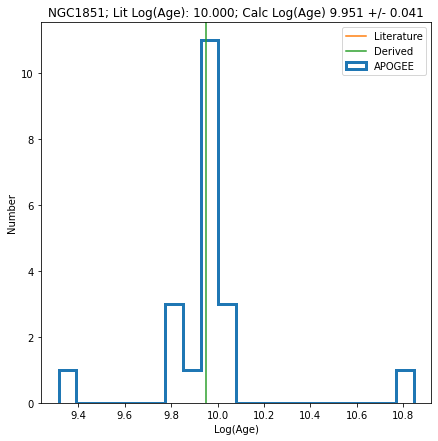

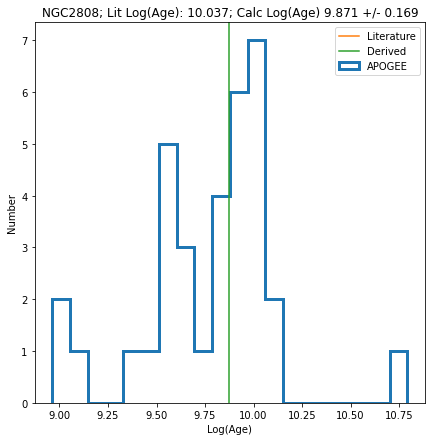

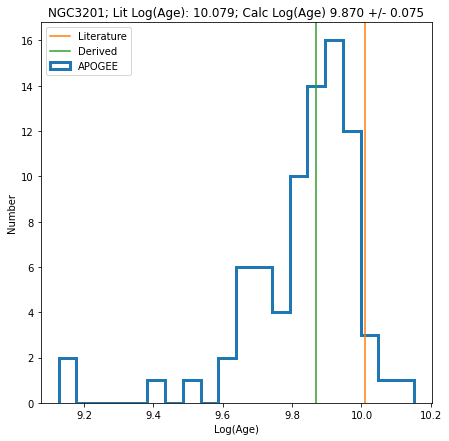

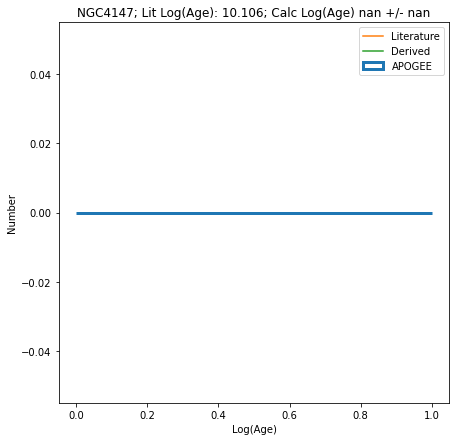

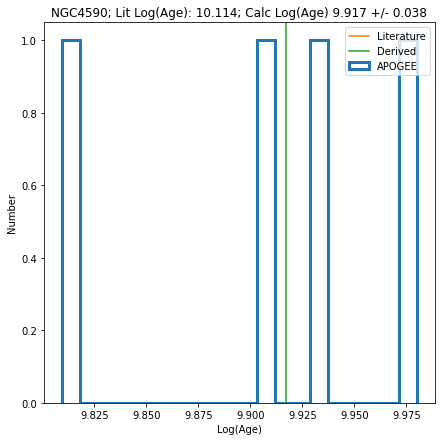

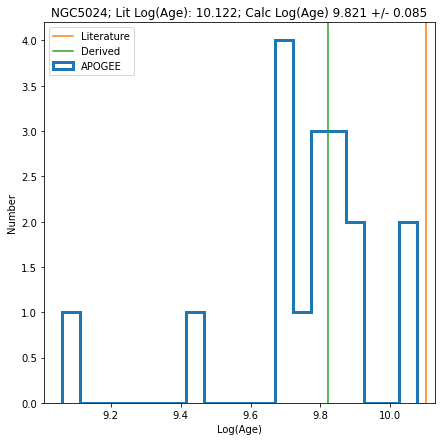

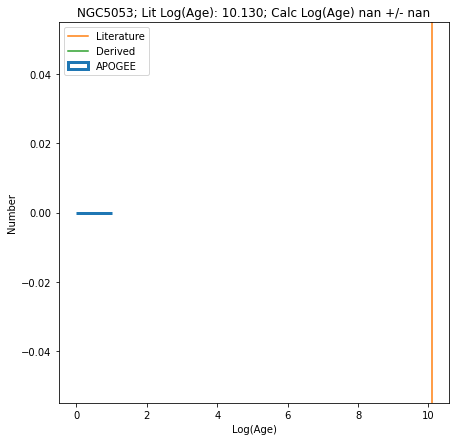

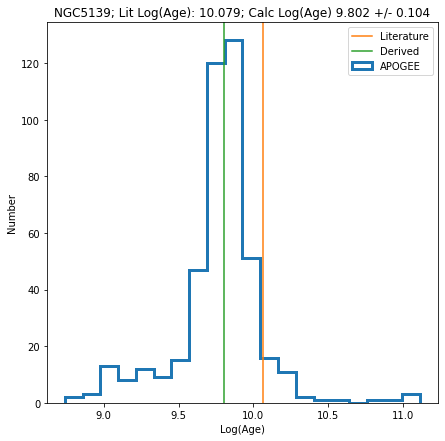

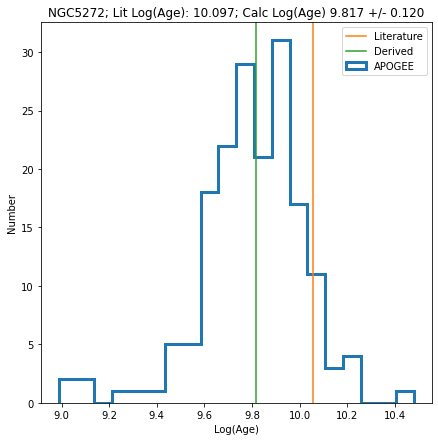

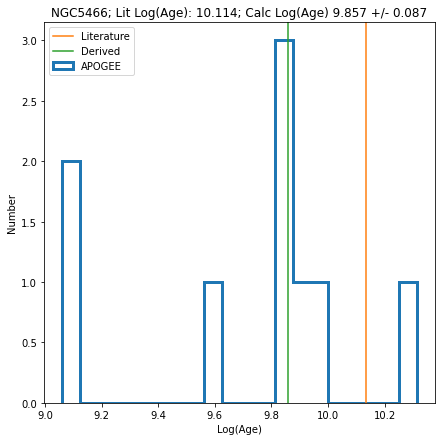

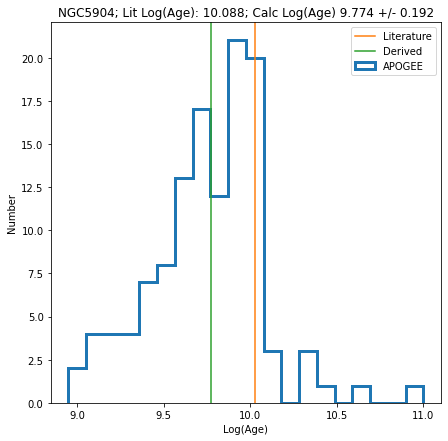

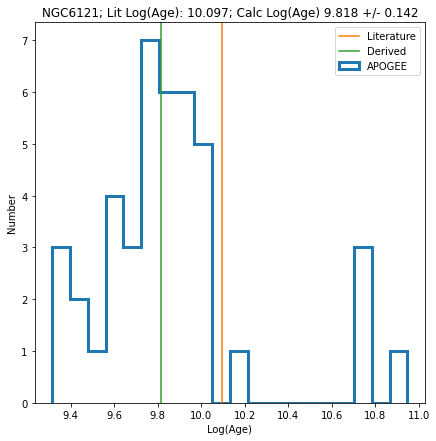

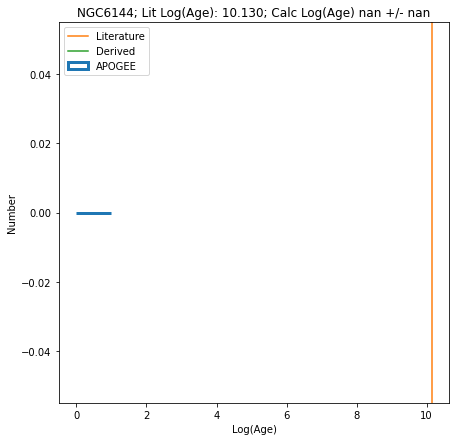

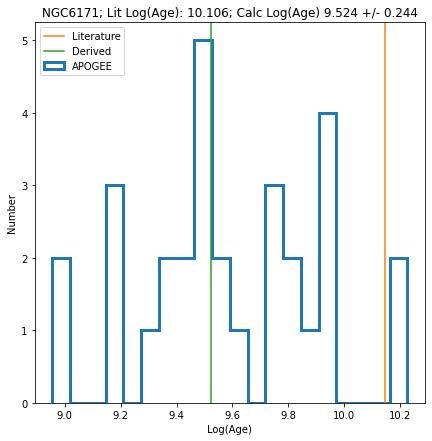

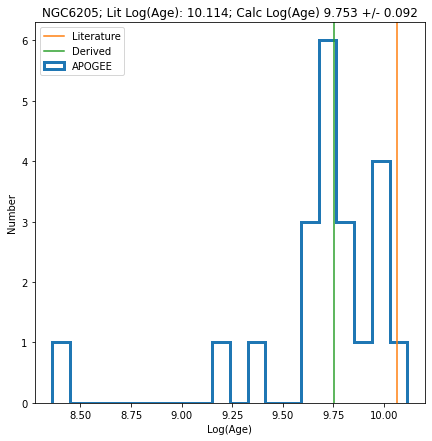

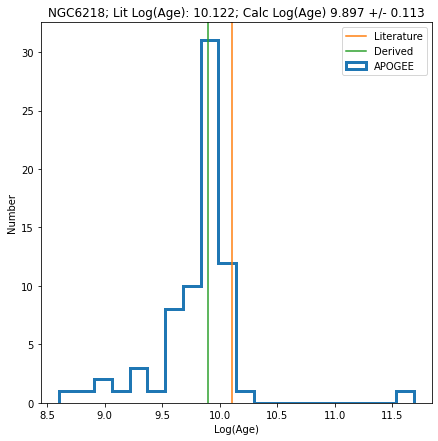

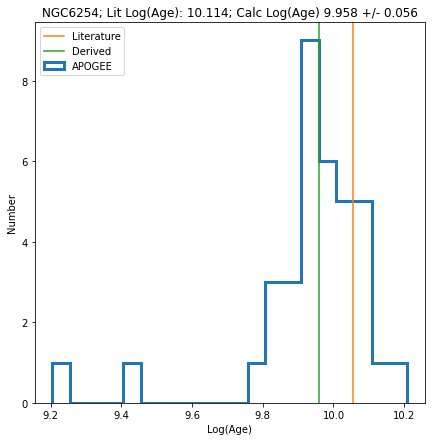

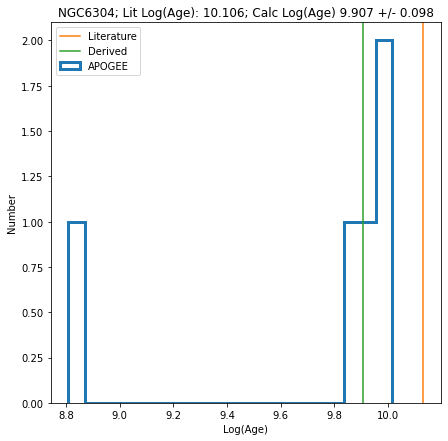

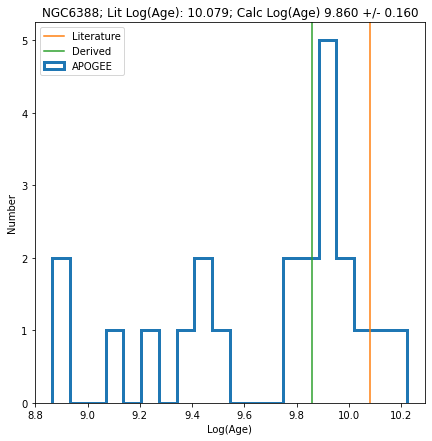

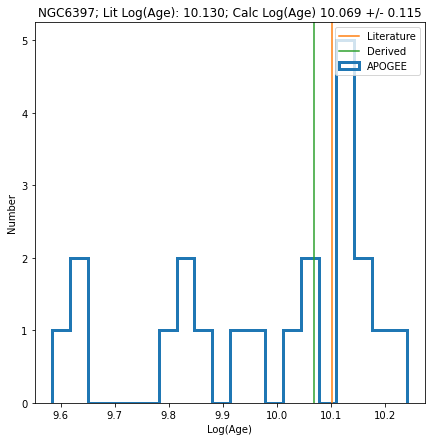

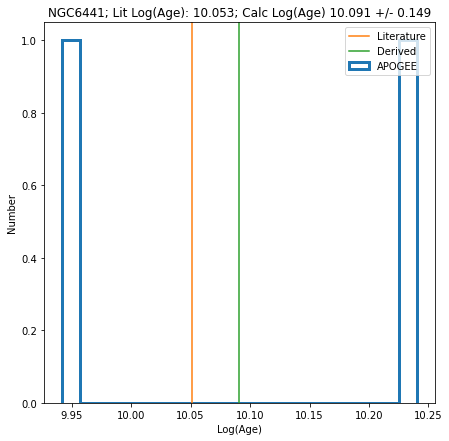

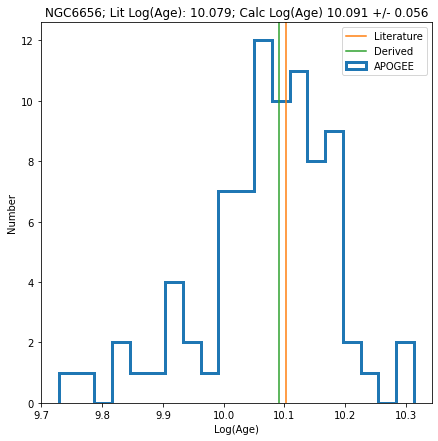

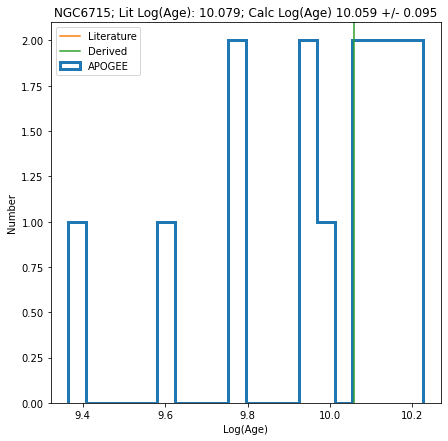

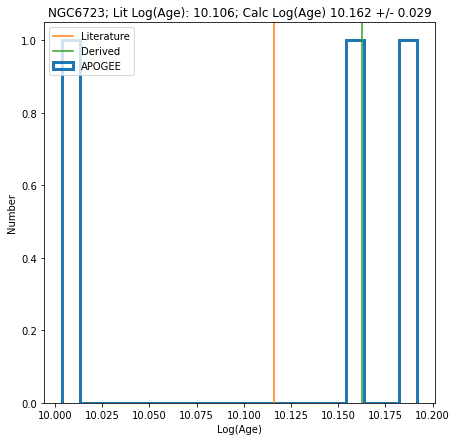

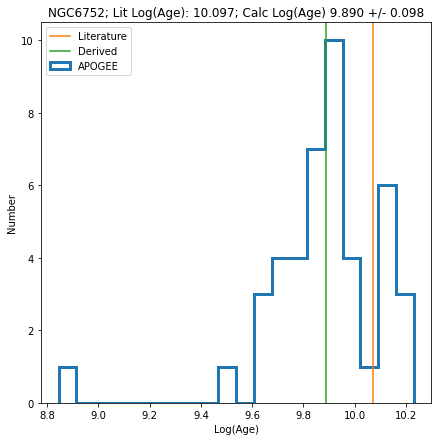

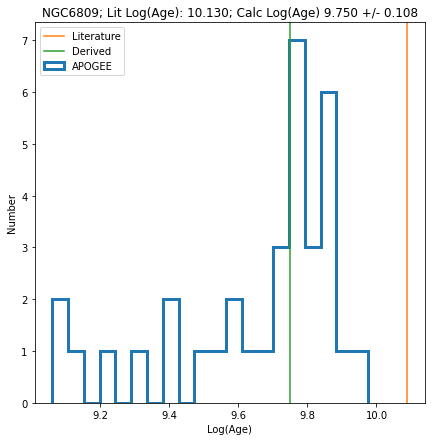

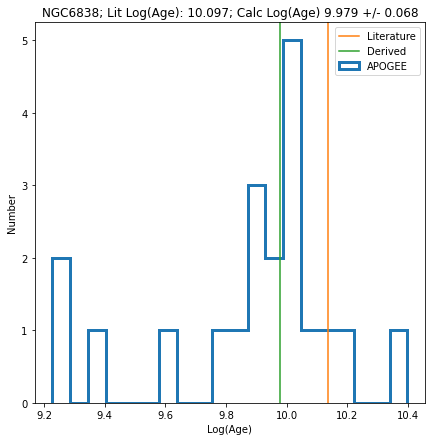

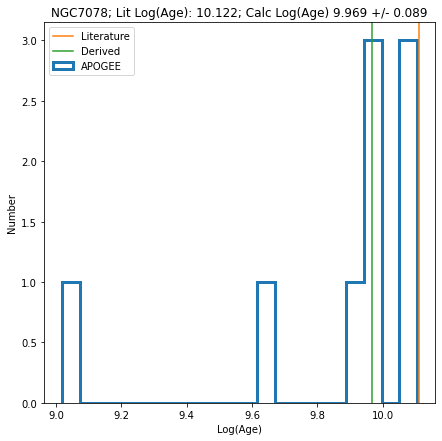

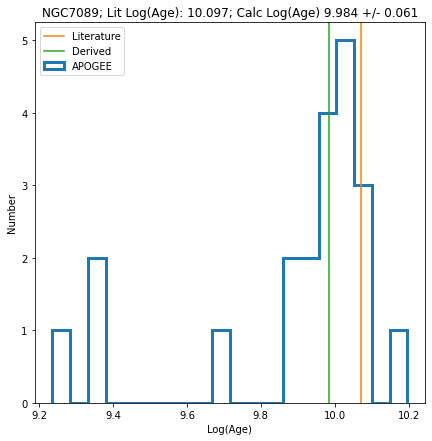

In [23]:
for i in range(len(np.squeeze(s2_ind))):
    clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
    plt.figure(figsize=[7,7])
    plt.hist(parages[clus],histtype='step',lw=3.0,bins=20,label='APOGEE')
    plt.axvline((np.log10(np.asarray(clus_ages)*10**9)[s2_ind][i]),c='tab:orange',label='Literature')
    plt.axvline(np.median(parages[clus]),c='tab:green',label='Derived')
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age']*10**9)[s2_ind][i]),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    plt.xlabel(r'Log(Age)')
    plt.ylabel(r'Number')
    plt.show()

In [25]:
close_age = []
med_age = []
close_feh = []
med_feh = []
for i in apogee_clus_idx2:
    use_age = np.median(parages[i])
    med_age.append(np.median(parages[i]))
    use_feh = np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i]))
    med_feh.append(np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i])))
    
    close_age.append(closest(use_age,parsec['logAge']))
    close_feh.append(closest(use_feh,parsec['MH']))
    
supp2_close_age = []
for j in np.asarray(clus_ages)[s2_ind]:
    supp2_close_age.append(closest(np.log10(j*(10**9)),parsec['logAge']))

In [26]:
supp2_close_age

[8.92942,
 8.92942,
 10.01072,
 8.92942,
 8.92942,
 10.102089999999999,
 10.09167,
 10.06258,
 10.0569,
 10.13354,
 10.02325,
 10.096910000000001,
 10.1383,
 10.14613,
 10.06819,
 10.102089999999999,
 10.0569,
 10.13354,
 10.08099,
 10.102089999999999,
 10.05115,
 10.102089999999999,
 8.92942,
 10.11394,
 10.06819,
 10.09167,
 10.1383,
 10.11394,
 10.06819]

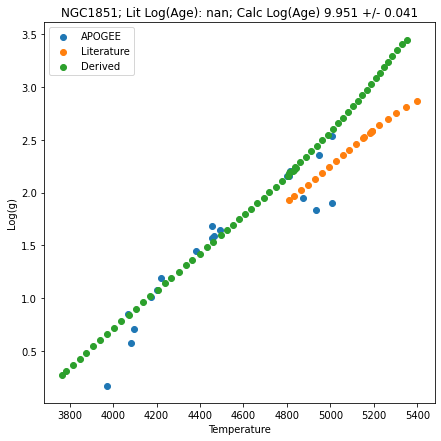

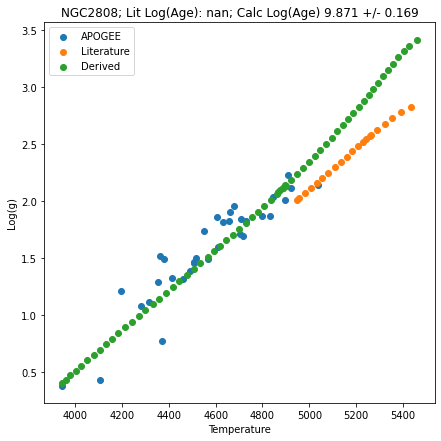

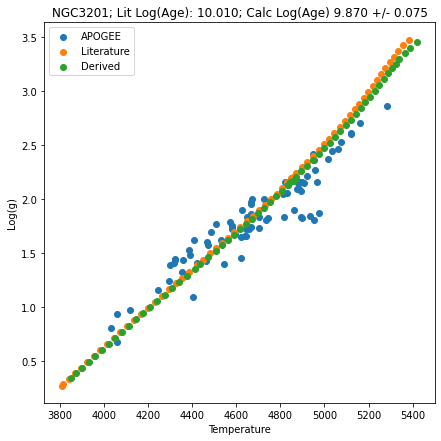

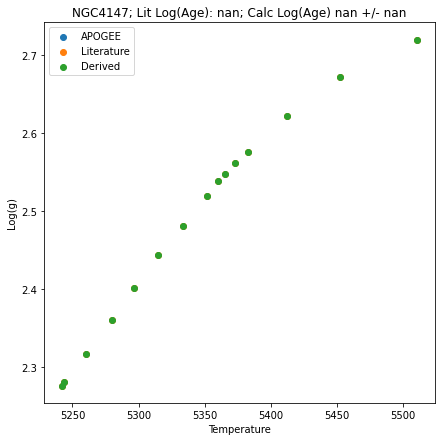

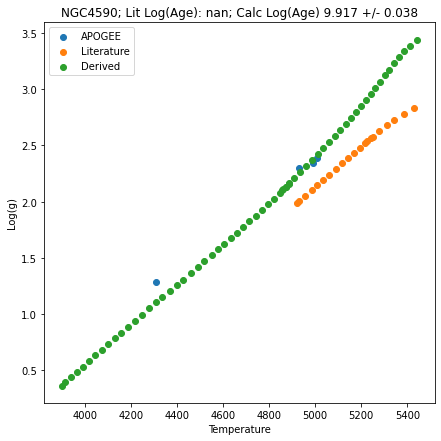

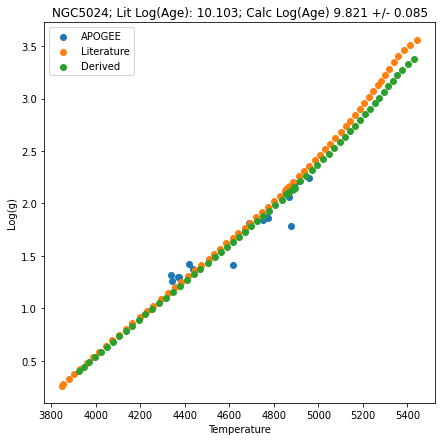

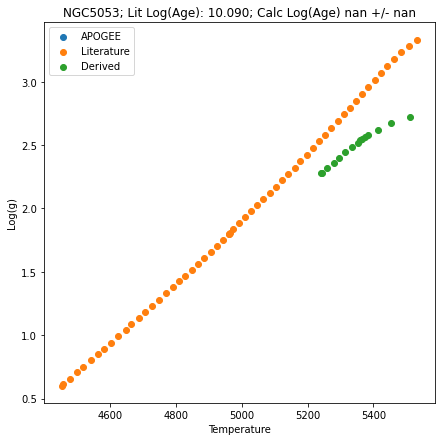

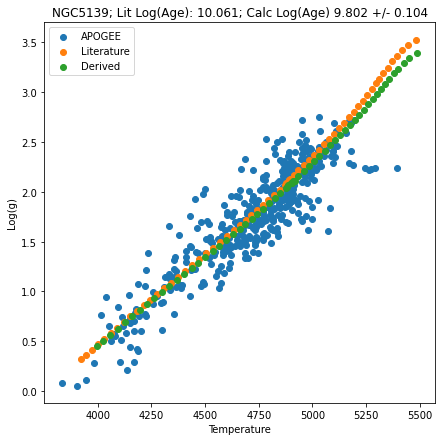

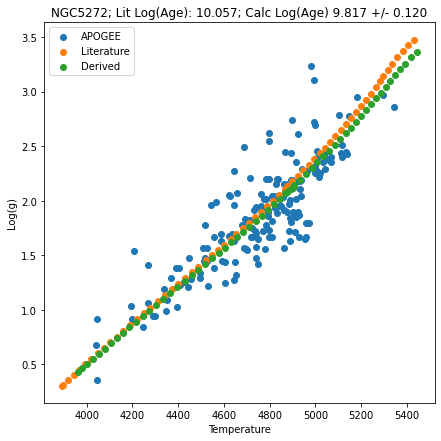

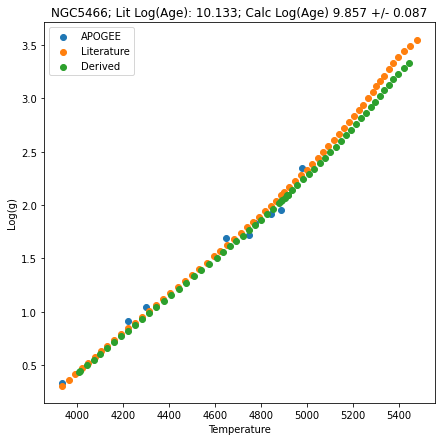

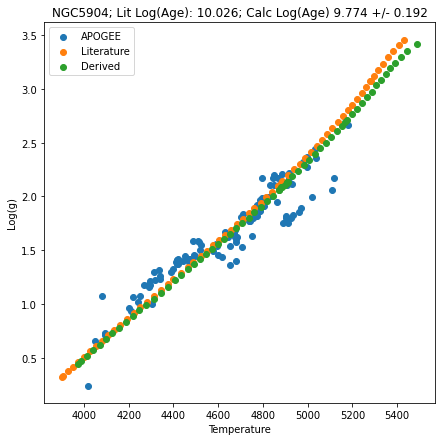

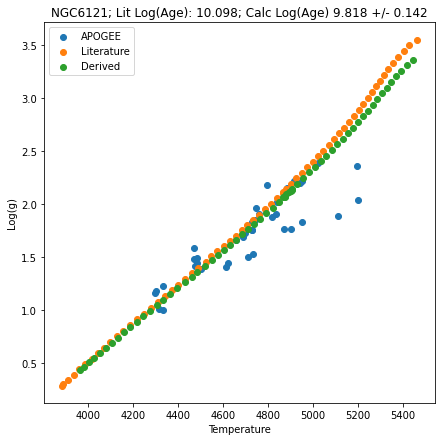

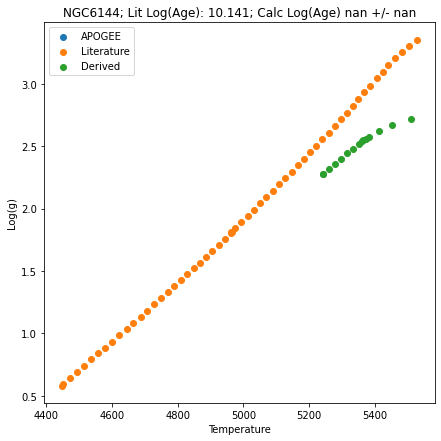

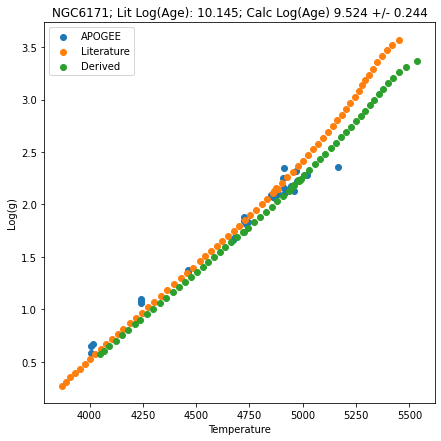

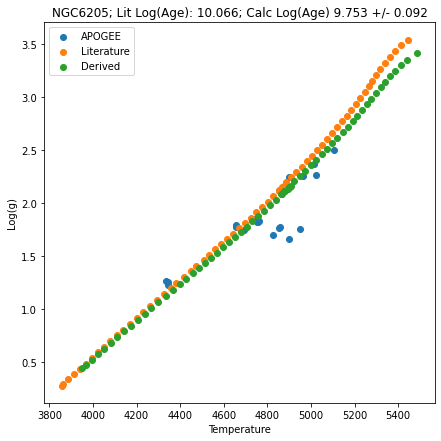

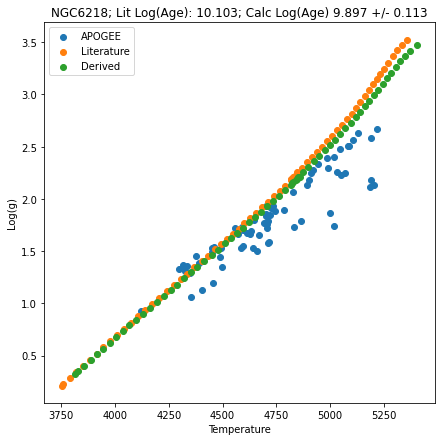

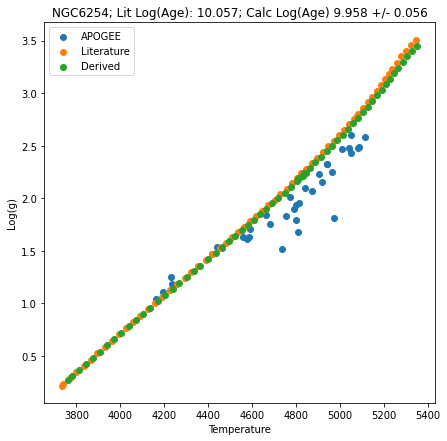

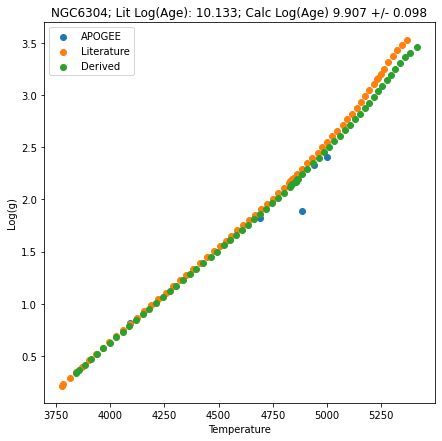

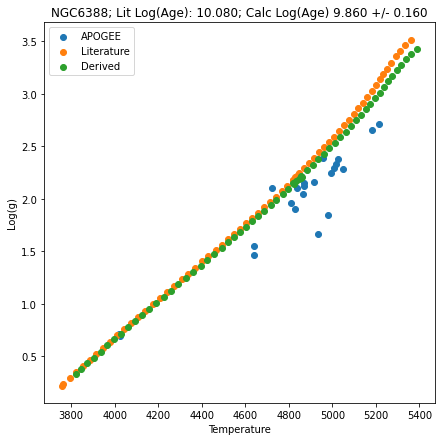

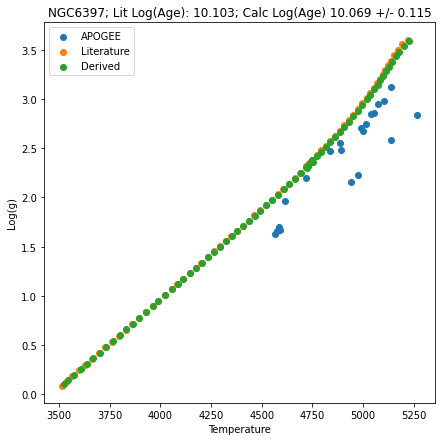

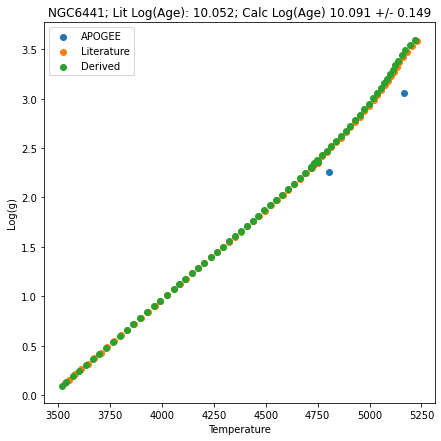

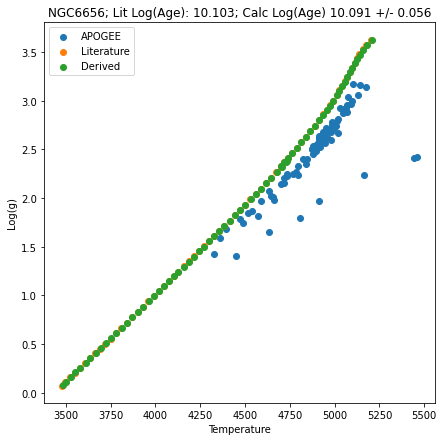

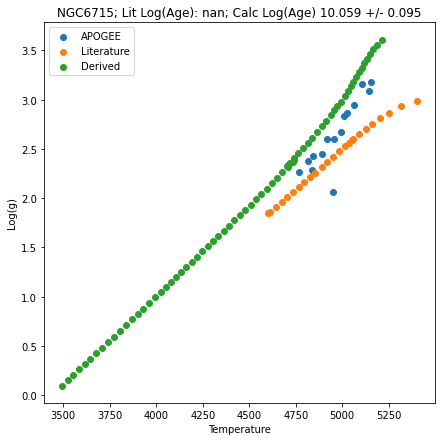

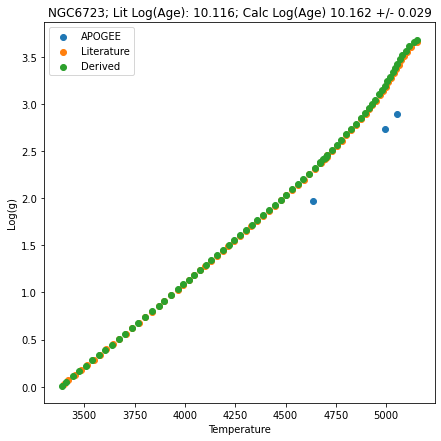

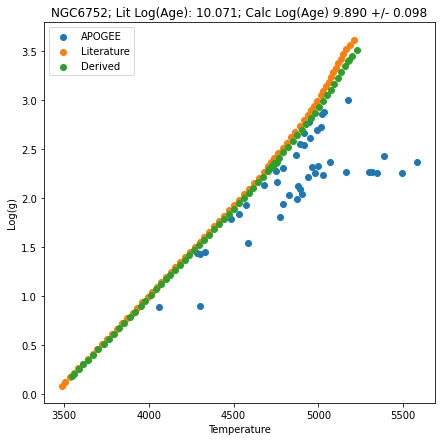

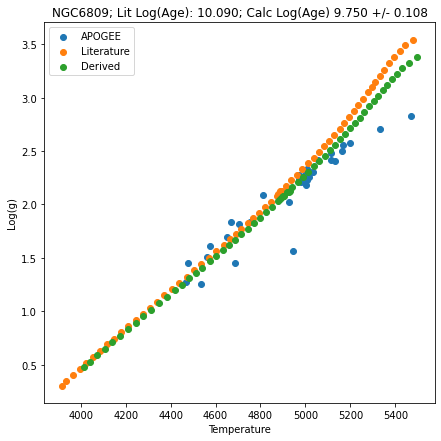

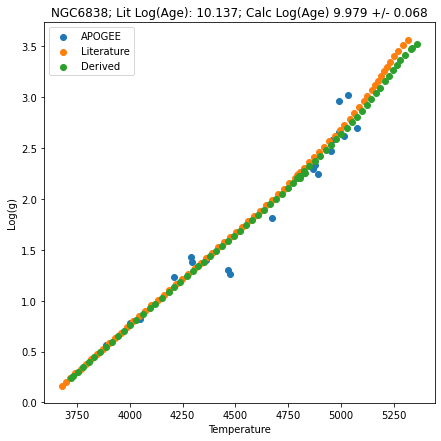

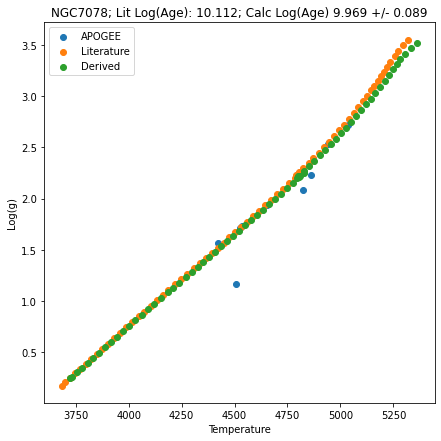

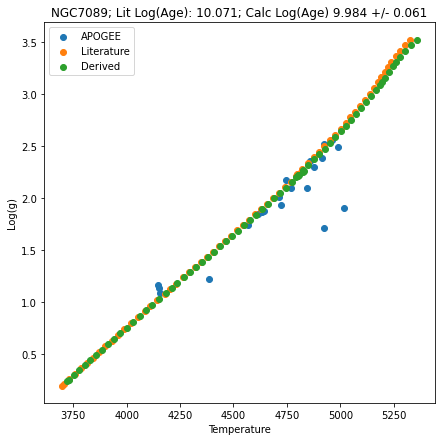

In [52]:
derived = [] 
derived_err = []
lits = []
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&
                                       (gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
    pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
    
    plt.scatter(gcs['TEFF'][clus],gcs['LOGG'][clus],label='APOGEE')
    plt.scatter(10**parsec['logTe'][theo],parsec['logg'][theo],label='Literature')
    plt.scatter(10**parsec['logTe'][pred],parsec['logg'][pred],label='Derived')
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(clus_ages)[s2_ind][i]*10**9),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    
    derived.append(np.median(parages[clus]))
    derived_err.append(afunc.mad(parages[clus]))
    lits.append(np.log10(np.asarray(clus_ages)[s2_ind][i]*10**9))
    
    plt.xlabel(r'Temperature')
    plt.ylabel(r'Log(g)')
    plt.show()

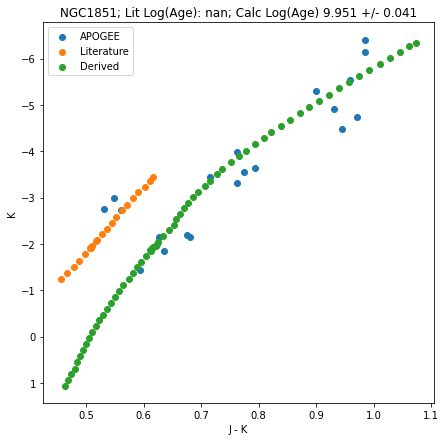

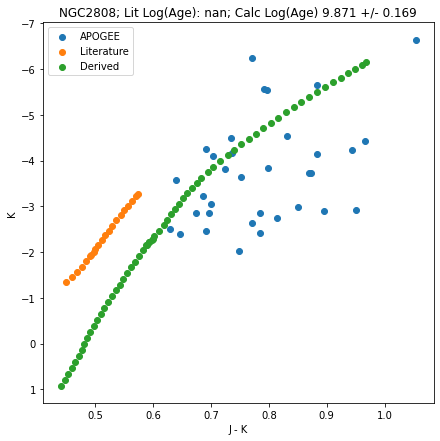

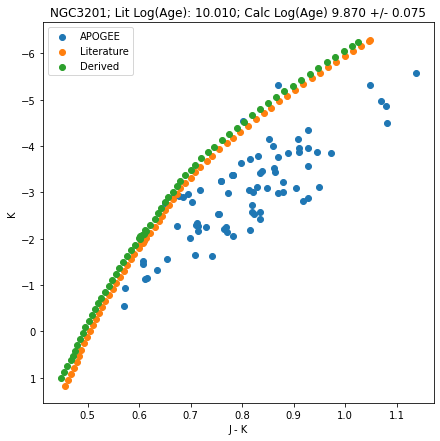

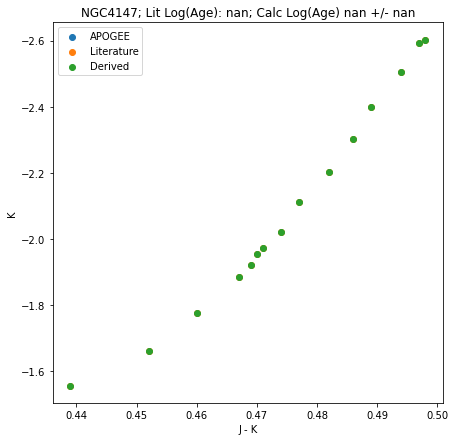

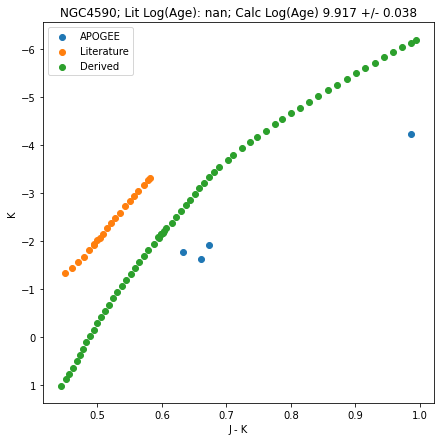

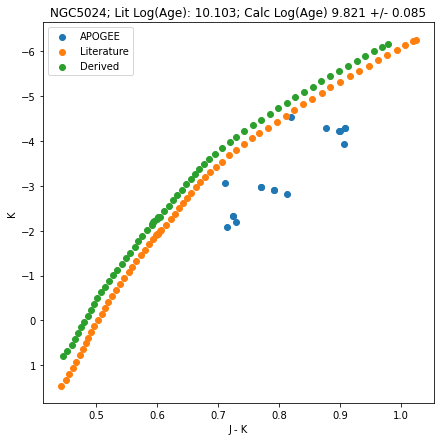

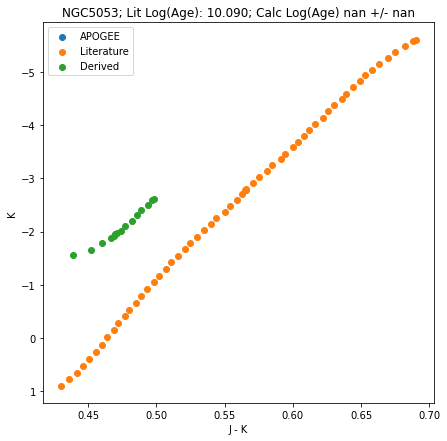

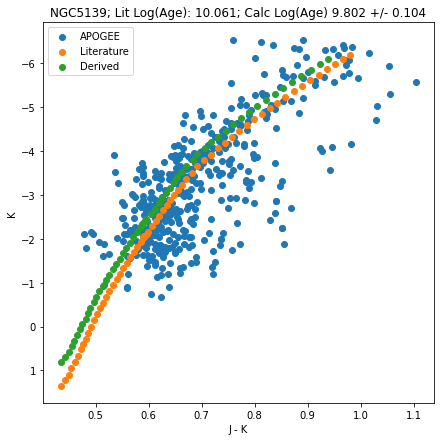

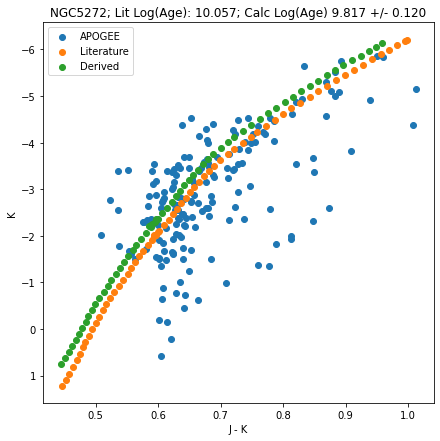

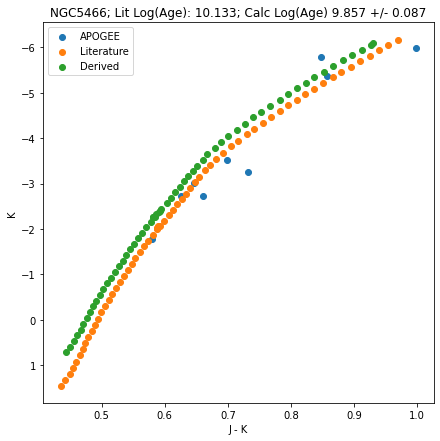

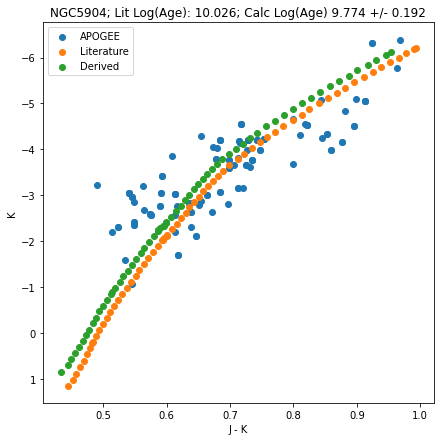

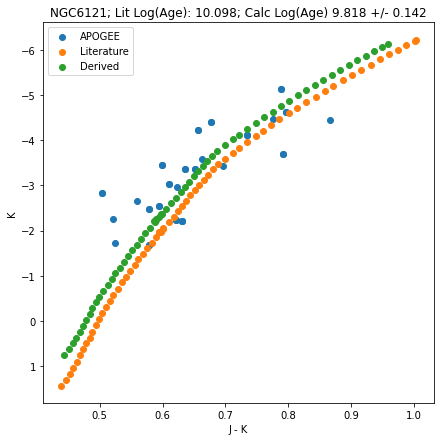

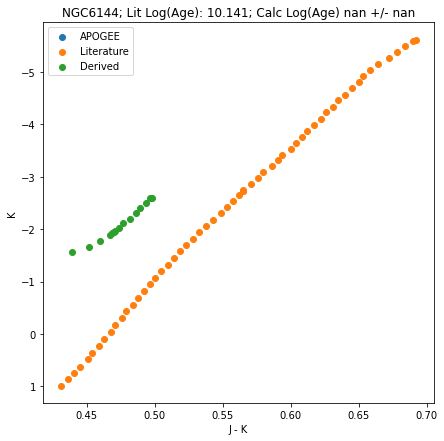

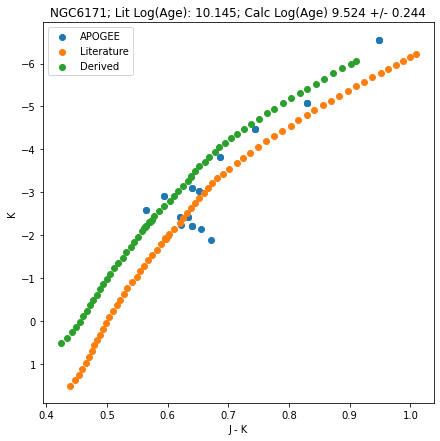

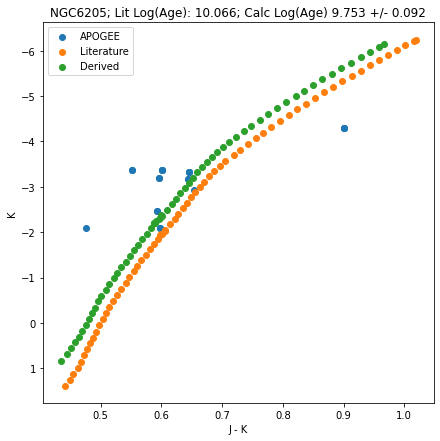

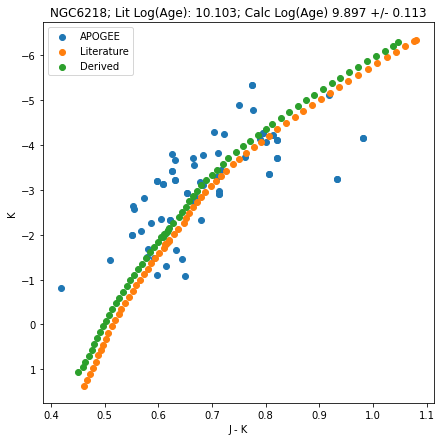

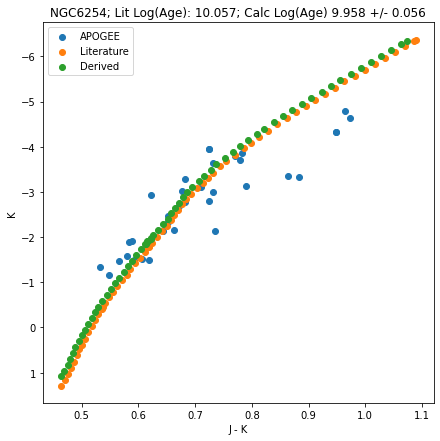

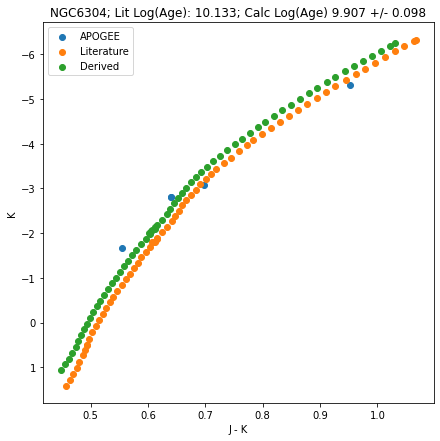

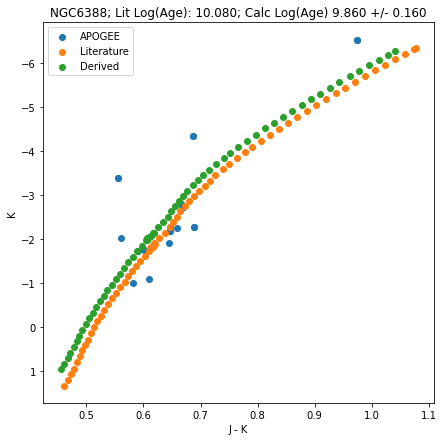

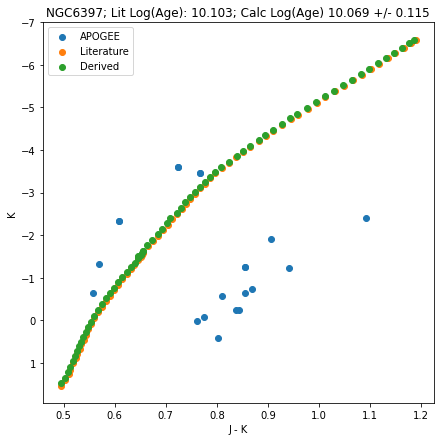

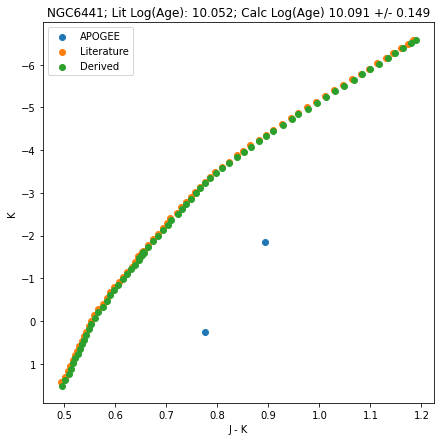

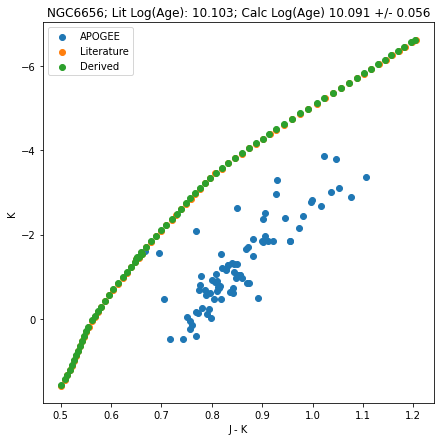

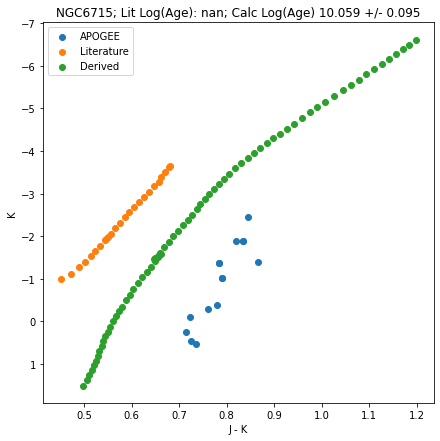

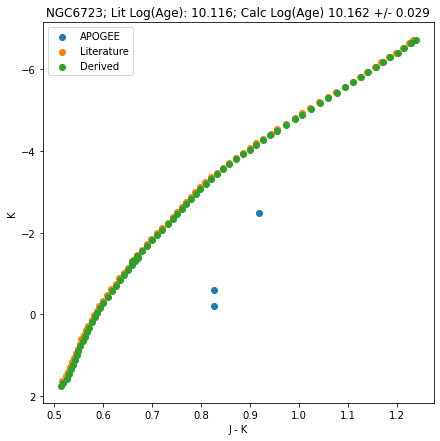

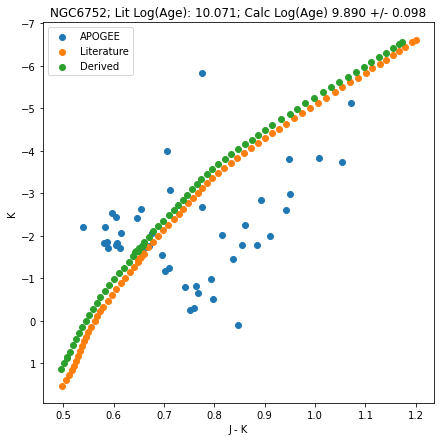

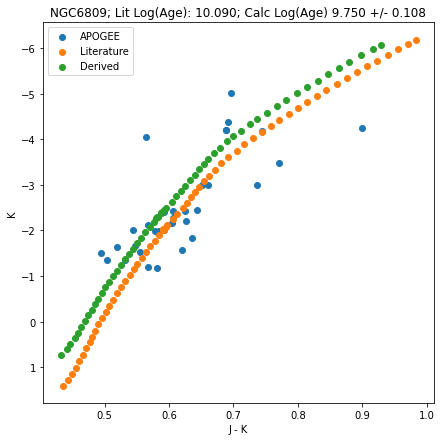

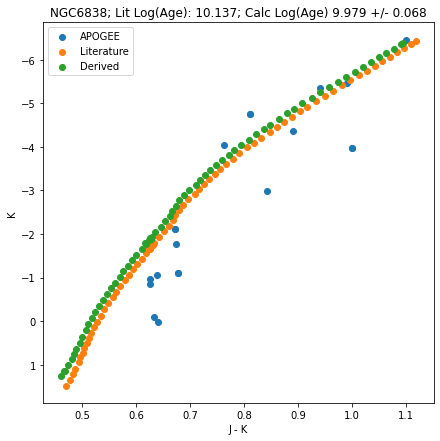

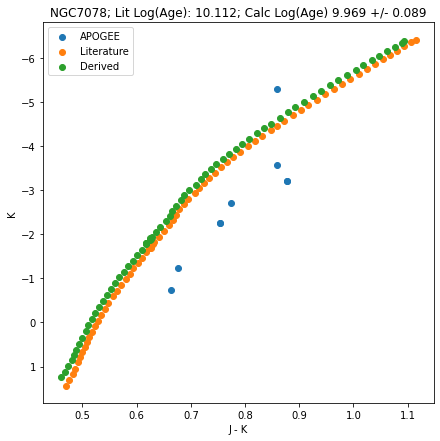

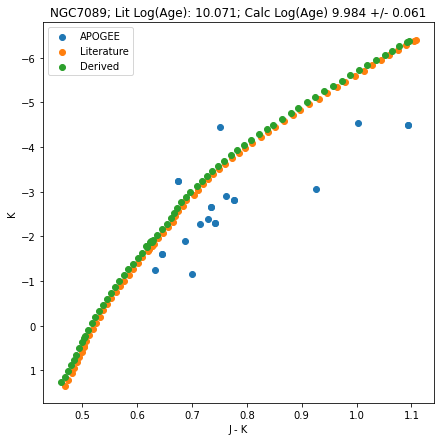

In [54]:
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names[np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))]==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh[i]))
    pred = np.where((parsec['logAge']==close_age[i])&(parsec['MH']==close_feh[i]))
    
    plt.scatter((gcs['J']-gcs['K'])[clus],gcs_ksmag[clus],label='APOGEE')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[theo],parsec['Ksmag'][theo],label='Literature')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[pred],parsec['Ksmag'][pred],label='Derived')
    
    plt.legend()
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(clus_ages)[s2_ind][i]*10**9),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

In [55]:
### NGC6254
print(np.log10((np.asarray(clus_ages)*10**9))[np.where(np.asarray(supp2['Cluster'])[s2_ind]=='NGC6254')])
print(np.asarray(med_age)[np.where(np.asarray(supp2['Cluster'])[s2_ind]=='NGC6254')])

[10.06145248]
[9.95801527]


In [56]:
print(np.where(np.asarray(supp2['Cluster'])[s2_ind]=='NGC6254'))
print(np.asarray(supp2['Cluster'])[s2_ind][16])
print(derived[16])
print(lits[16])

(array([16]),)
NGC6254
9.958015266730417
10.056523724079101


In [57]:
print('lits',len(lits))
print('xmatch',len(np.asarray(supp2['Cluster'])[s2_ind]))

lits 29
xmatch 29


In [58]:
np.log10(np.asarray(supp2['Age'])[s2_ind]*10**9)==lits

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

In [59]:
np.asarray(derived)-np.asarray(lits)

array([        nan,         nan, -0.1401041 ,         nan,         nan,
       -0.28157084,         nan, -0.25927998, -0.23944291, -0.27562177,
       -0.25220761, -0.27986094,         nan, -0.62043101, -0.31330155,
       -0.20571468, -0.09850846, -0.22586254, -0.22060865, -0.03368695,
        0.03948487, -0.01145712,         nan,  0.04646893, -0.18153052,
       -0.33952372, -0.15789638, -0.14301413, -0.08703796])

In [60]:
print(derived[10])
print(lits[10])

9.77391691097284
10.026124516745451


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


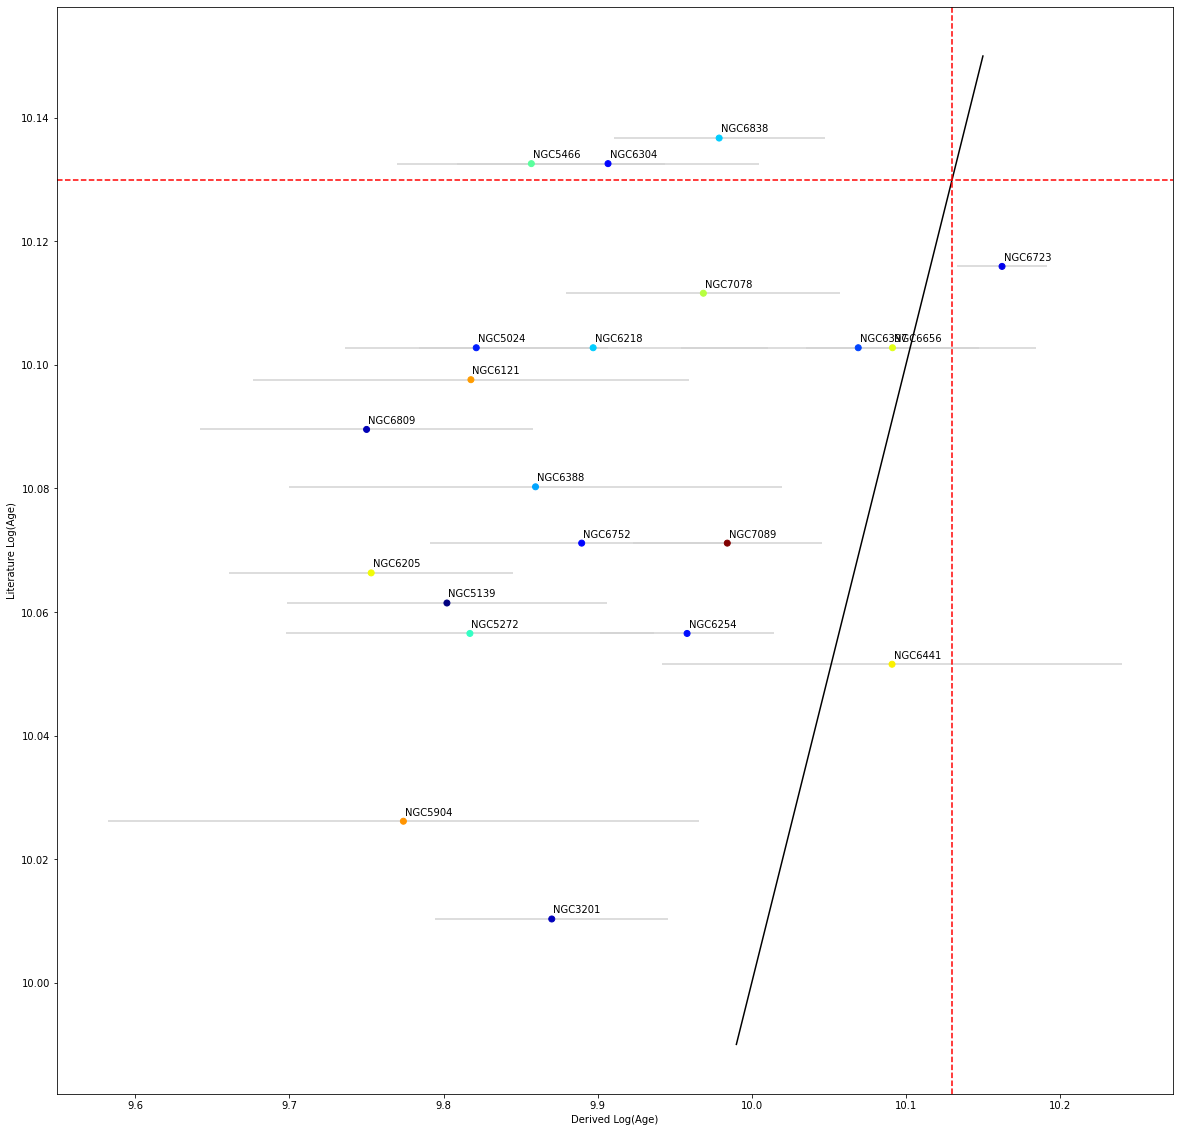

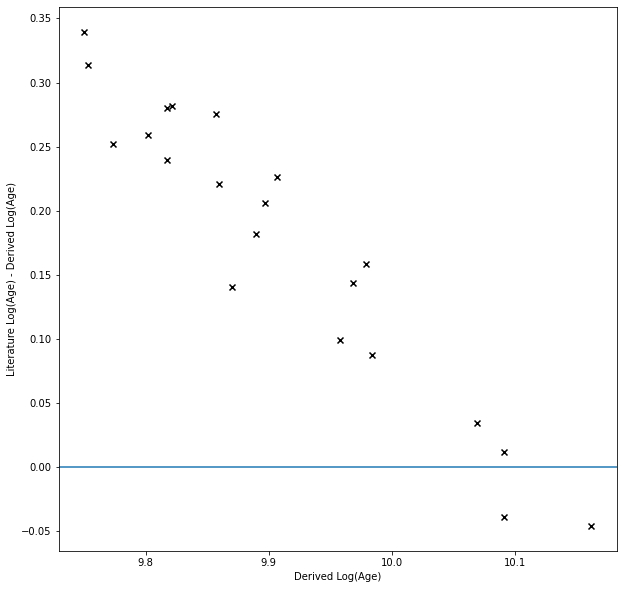

In [61]:
fin = np.where((np.isfinite(derived)==True)&(np.asarray(supp2['Cluster'])[s2_ind]!='NGC6171'))

plt.figure(figsize=[20,20])
plt.errorbar(np.asarray(derived)[fin],np.asarray(lits)[fin],xerr=np.asarray(derived_err)[fin],ls='none',
             c='lightgrey',zorder=1)
plt.scatter(np.asarray(derived)[fin],np.asarray(lits)[fin],c=np.random.random(len(derived))[fin],zorder=2,cmap='jet')
plt.plot([9.99,10.15],[9.99,10.15],c='k')

for i in range(len(np.asarray(derived)[fin])):
    plt.text(np.asarray(derived)[fin][i]*(1.+0.0001),np.asarray(lits)[fin][i]*(1.+0.0001),
             '{}'.format(np.asarray(supp2['Cluster'])[s2_ind][fin][i]))

plt.axhline(10.13,c='r',ls='--')
plt.axvline(10.13,c='r',ls='--')

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age)')
plt.show()

###
plt.figure(figsize=[10,10])
plt.scatter(x=np.asarray(derived)[fin],y=np.subtract(lits,derived)[fin],c='k',marker='x')
plt.axhline(0.0)

plt.xlabel('Derived Log(Age)')
plt.ylabel('Literature Log(Age) - Derived Log(Age)')
plt.show()

In [62]:
zoff = np.polyfit(np.asarray(derived)[fin], np.subtract(np.asarray(lits)[fin],np.asarray(derived)[fin]), 1)
offpoly = np.poly1d(zoff)
print(offpoly)

 
nan x + nan


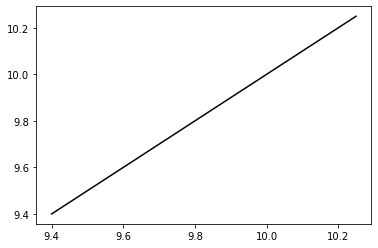

In [63]:
plt.scatter(np.asarray(derived)[fin],-offpoly(np.asarray(derived)[fin])+np.asarray(derived)[fin])
plt.plot([9.4,10.25],[9.4,10.25],c='k')

In [48]:
10**9.8/10**9

6.309573444801943

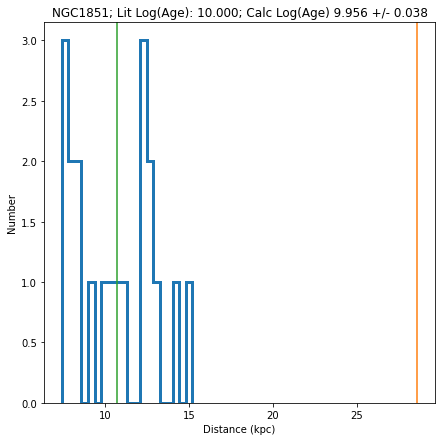

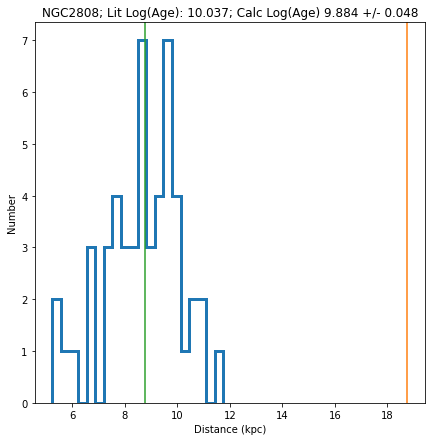

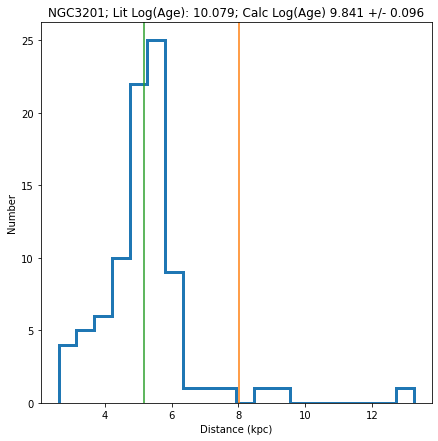

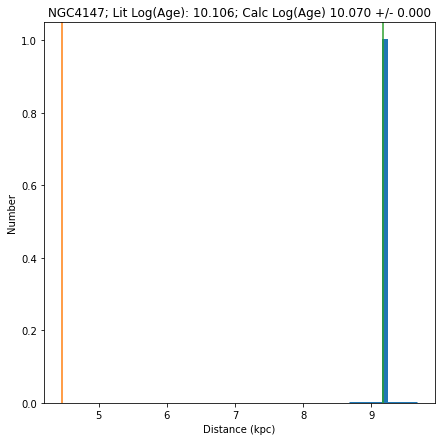

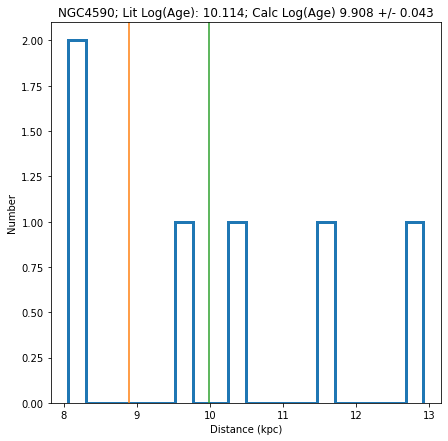

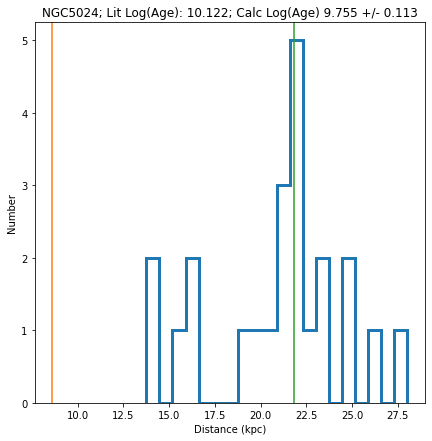

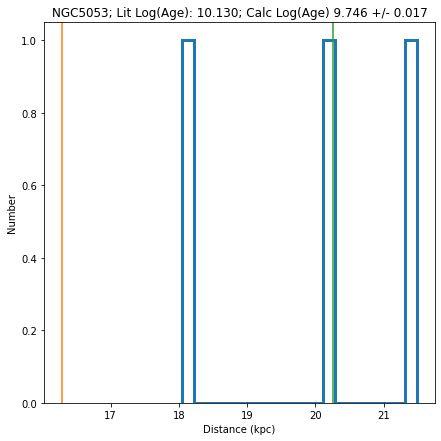

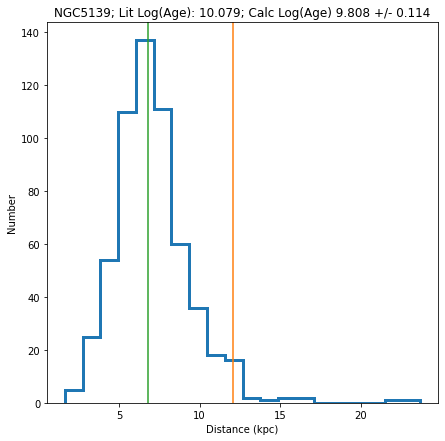

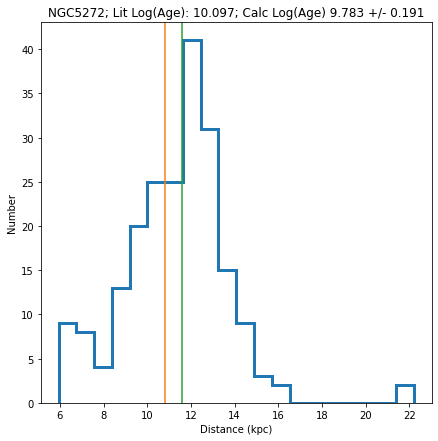

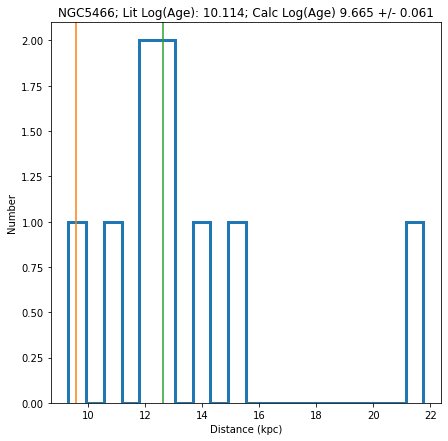

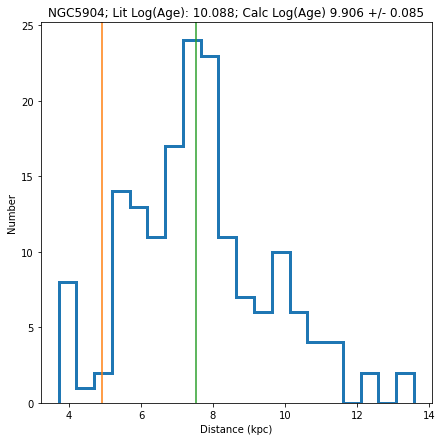

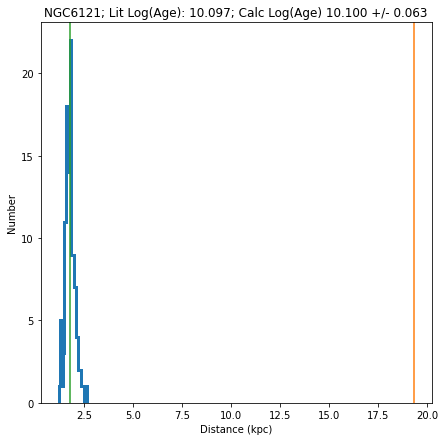

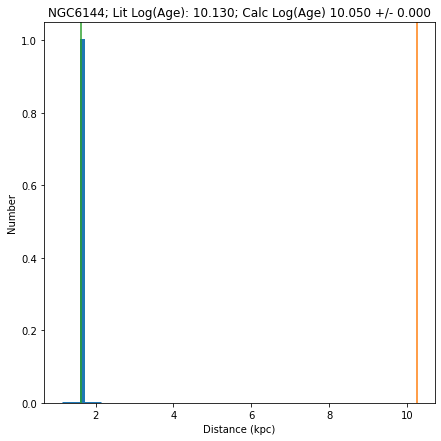

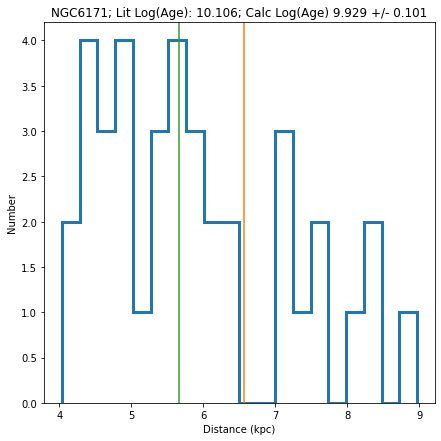

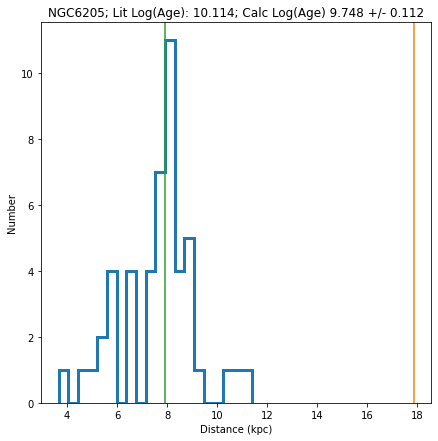

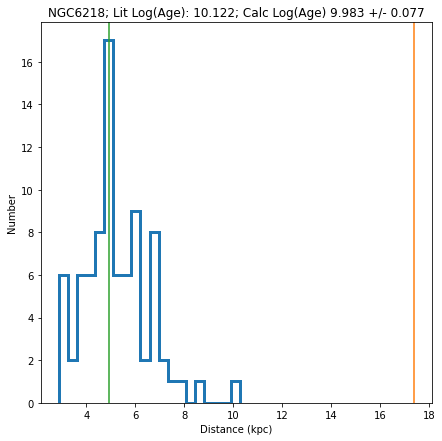

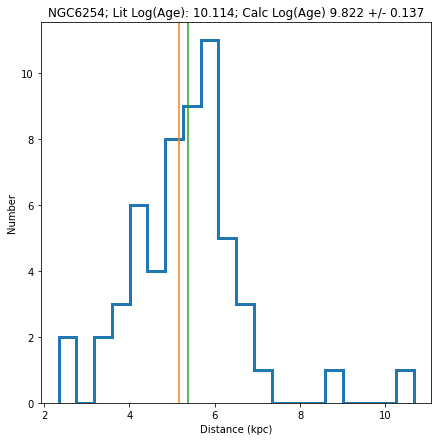

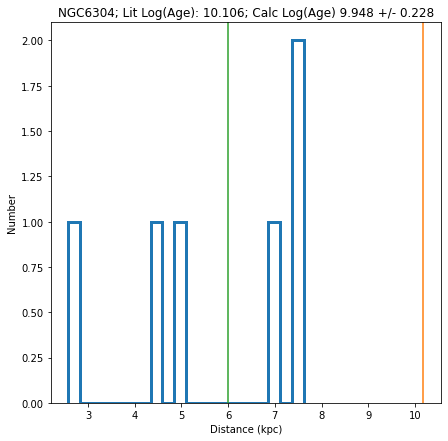

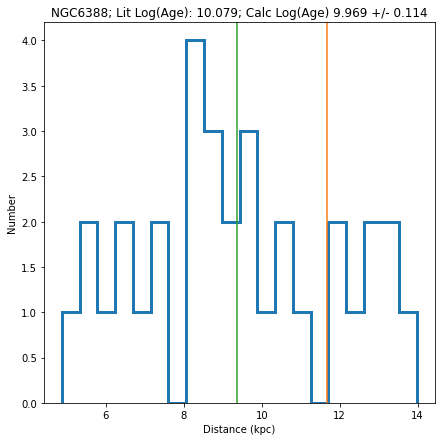

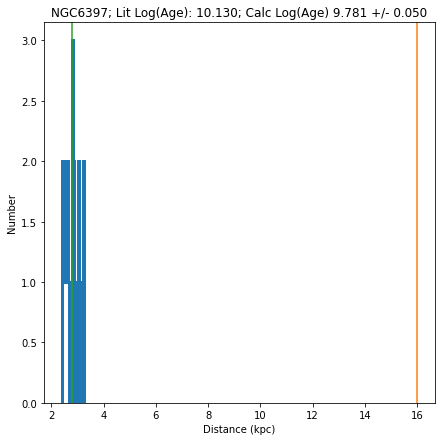

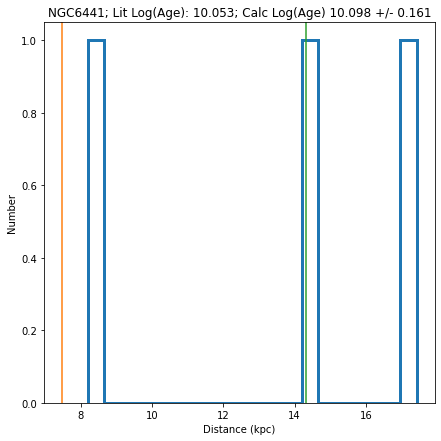

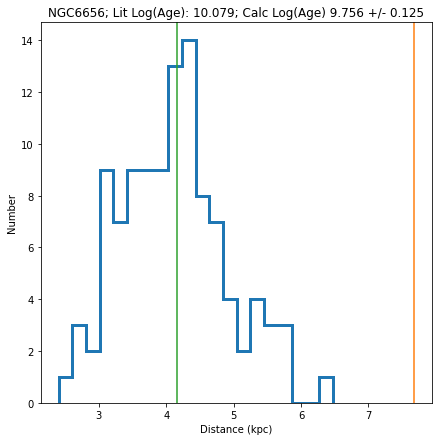

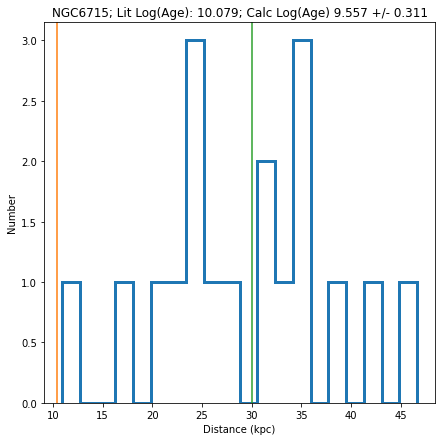

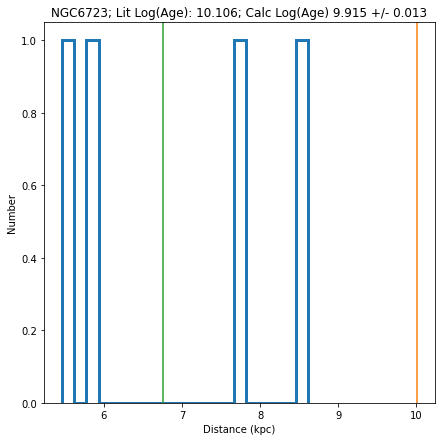

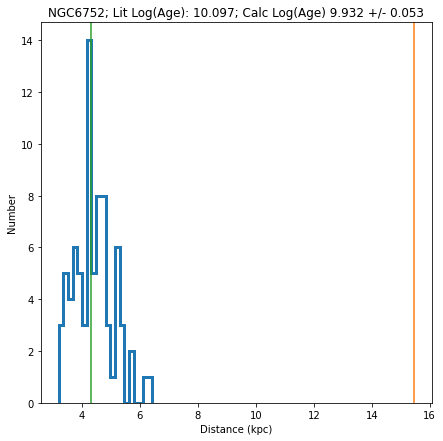

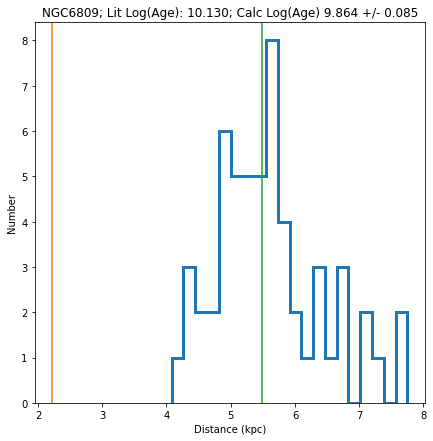

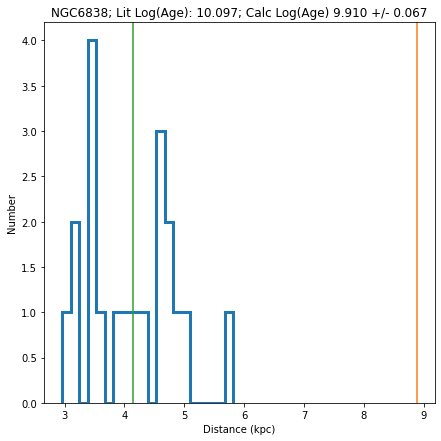

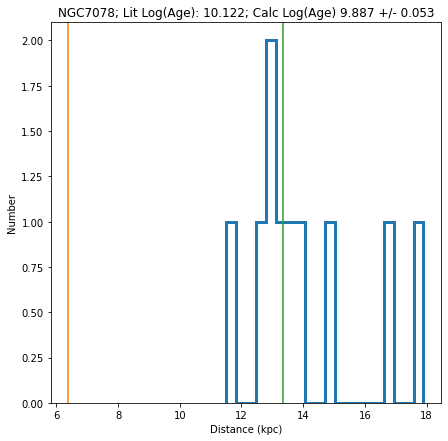

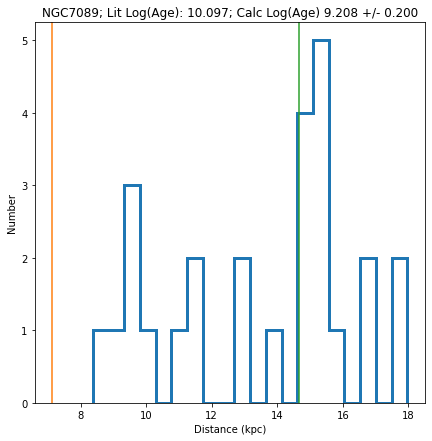

In [162]:
clusdist = 10**((supp2['Dist']+5.-supp2['Av'])/5.) 
diff_dist = []
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    plt.hist(gcs['distmed'][clus],histtype='step',lw=3.0,bins=20,label='APOGEE')
    plt.axvline(np.median(gcs['distmed'][clus]),color='tab:green',label='Observed')
    plt.axvline(clusdist[i]/1000.,c='tab:orange',label='Literature')
    
    
    diff_dist.append(np.asarray(clusdist[i])/1000.-np.median(gcs['distmed'][clus]))
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age']*10**9)[s2_ind][i]),
        np.median(parages[clus]),afunc.mad(parages[clus])))
    plt.xlabel(r'Distance (kpc)')
    plt.ylabel(r'Number')
    plt.show()

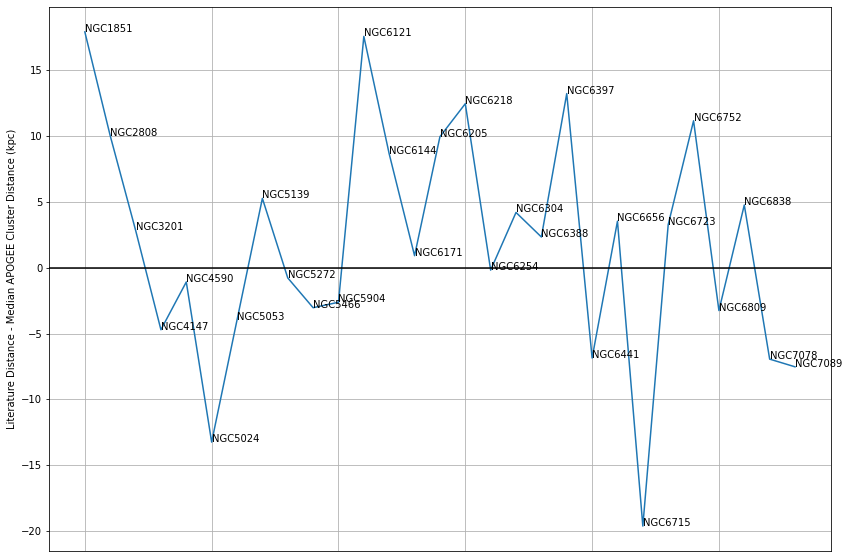

In [77]:
plt.figure(figsize=[14,10])
plt.plot(diff_dist)
plt.tick_params(axis='x',which='both',top=False,bottom=False,labelbottom=False)

plt.axhline(0,c='k')

for i in range(len(diff_dist)):
    plt.text(range(len(diff_dist))[i],diff_dist[i],'{}'.format(np.asarray(supp2['Cluster'])[s2_ind][i]))

plt.grid()
plt.ylabel(r'Literature Distance - Median APOGEE Cluster Distance (kpc)')
plt.show()

(array([  1.,   0.,   2.,  15., 160., 378., 252., 256., 290., 275.]),
 array([-1.0292716 , -0.8863756 , -0.7434796 , -0.60058355, -0.45768756,
        -0.31479156, -0.17189555, -0.02899954,  0.11389647,  0.2567925 ,
         0.39968848], dtype=float32),
 <a list of 10 Patch objects>)

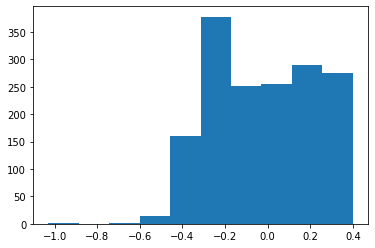

In [135]:
plt.hist(gcs['AL_FE'][np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))])

In [136]:
len(np.squeeze(np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))))/len(gcs)

0.745537757437071

In [137]:
supp2['Dist']

0     17.59
1     17.08
2     16.78
3     13.37
4     14.84
      ...  
64    19.51
65    18.63
66    17.25
67    17.01
68    17.47
Name: Dist, Length: 69, dtype: float64

<font size='45'>
    <b>
        Literature Distances
    </b>
</font>

In [163]:
clusdist = 10**((supp2['Dist']+5.-supp2['Av'])/5.)
dists = np.ones(len(gcs))
dists_err = np.ones(len(gcs))
for i in range(len(np.squeeze(s2_ind))):
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    dists[clus] = clusdist[i]/1000.
    dists_err[clus] = (0.461*clusdist[i]/1000.*np.sqrt(np.asarray(supp2['Dist_Sigma'][i])**2+
                                                 np.asarray(supp2['Av_Sigma'][i])**2))
    
#     diff_dist.append(np.asarray(clusdist[i])/1000.-np.median(gcs['distmed'][clus]))

In [164]:
age_dist_lit = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = gcs['AK_TARG'][i]
    dist = dists[i]
    dist_err = dists_err[i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        #_, _, dist = afunc.LMCdisk_cart(ra,dec)
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = np.abs(add_noise(dist,dist_err))
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,am_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist_lit.append(noise_ages)

parages_lit = [] 
devs_lit = []
for k in tqdm_notebook(range(len(age_dist_lit))):
    devs_lit.append(afunc.mad(age_dist_lit[k]))
    parages_lit.append(np.median(age_dist_lit[k]))
devs_lit = np.asarray(devs_lit)
parages_lit = np.asarray(parages_lit)

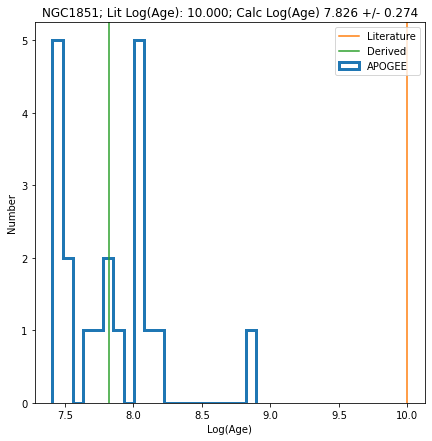

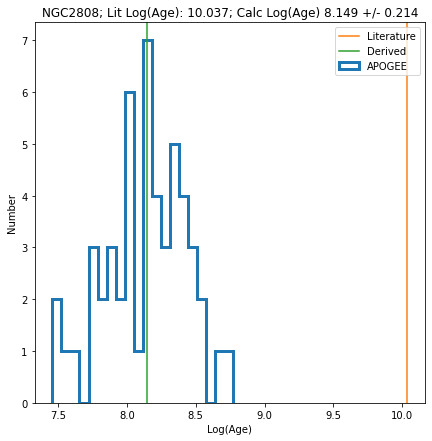

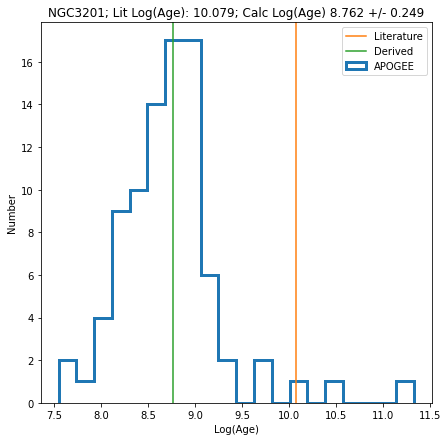

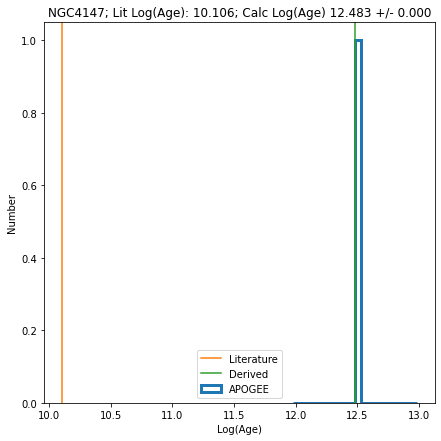

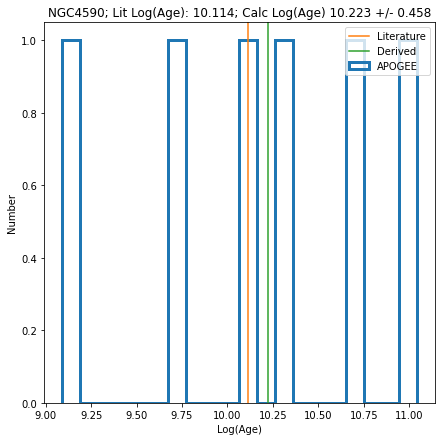

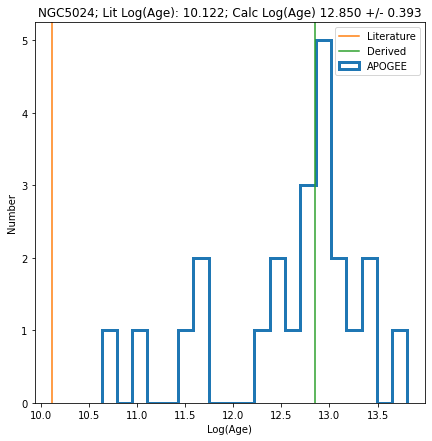

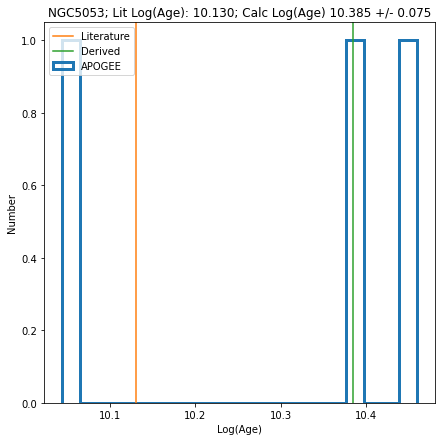

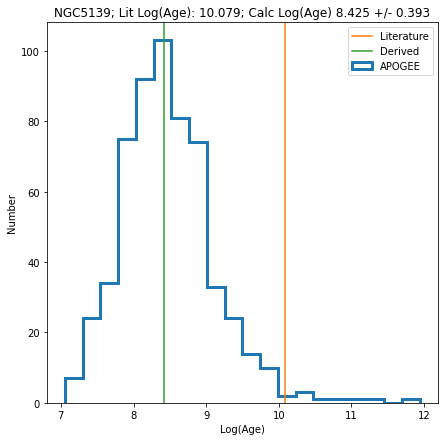

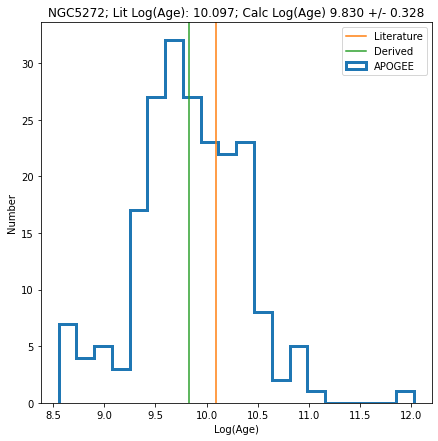

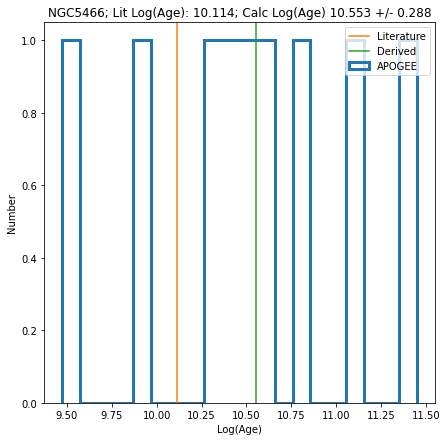

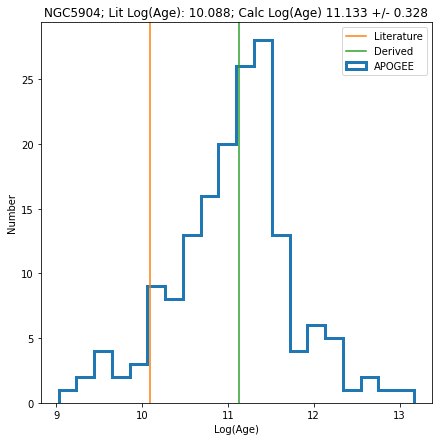

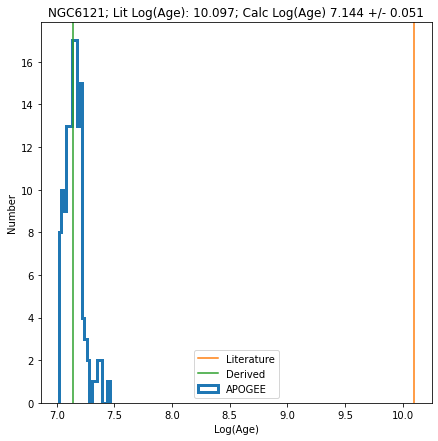

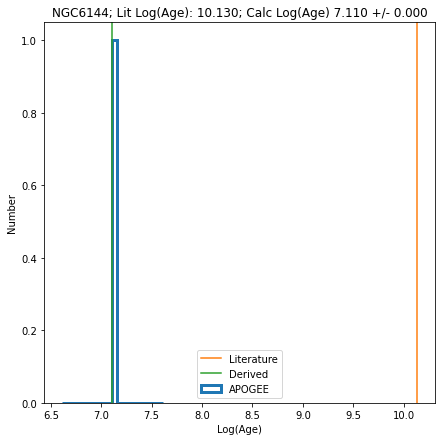

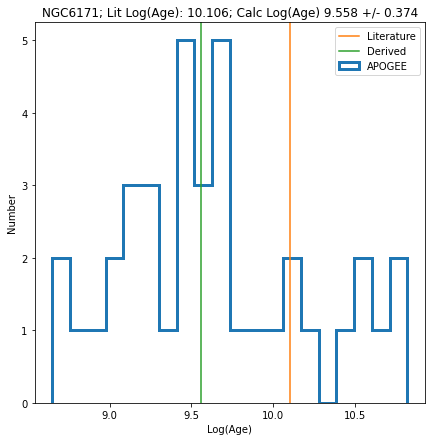

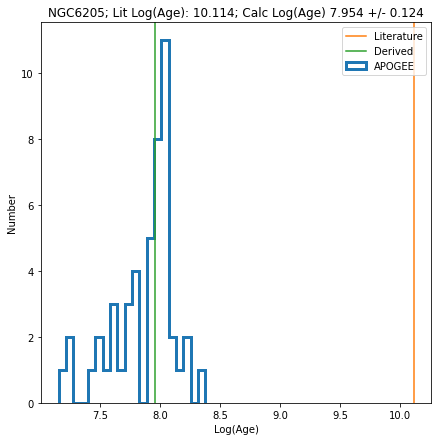

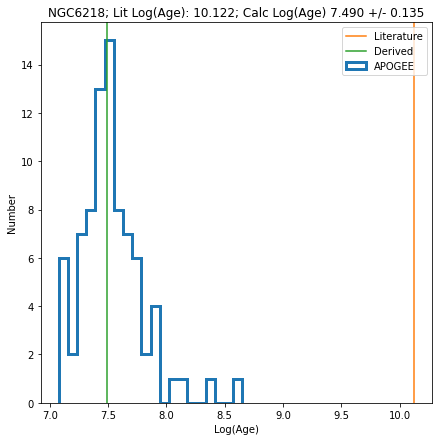

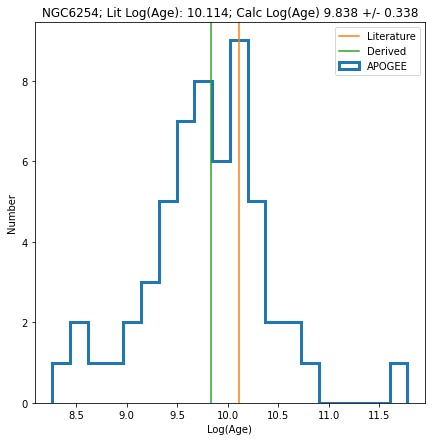

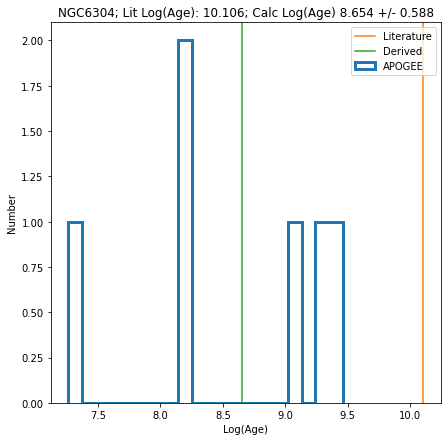

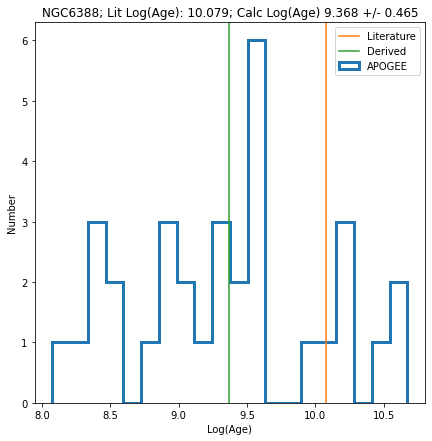

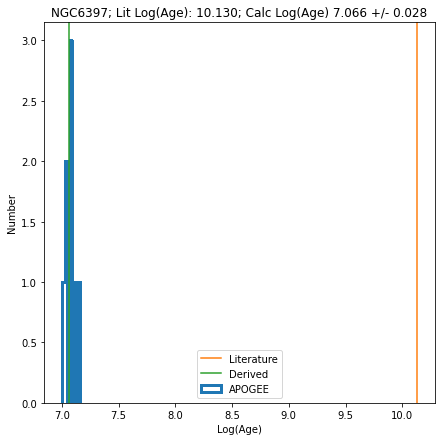

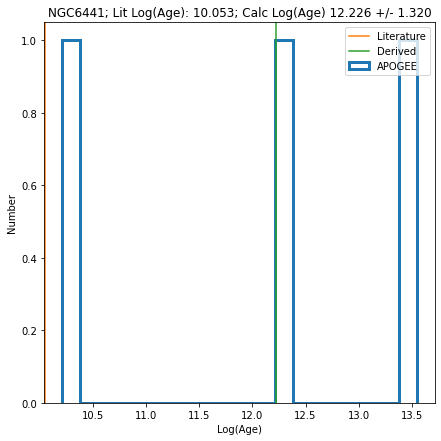

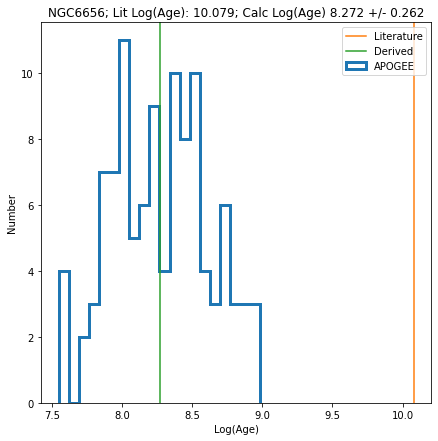

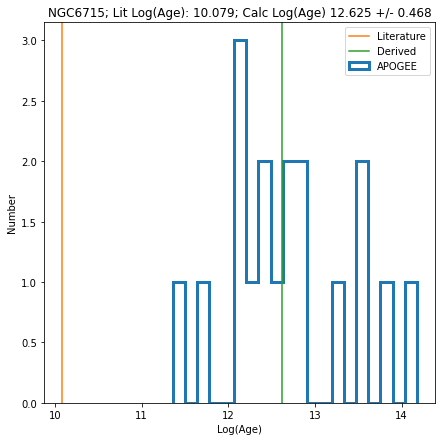

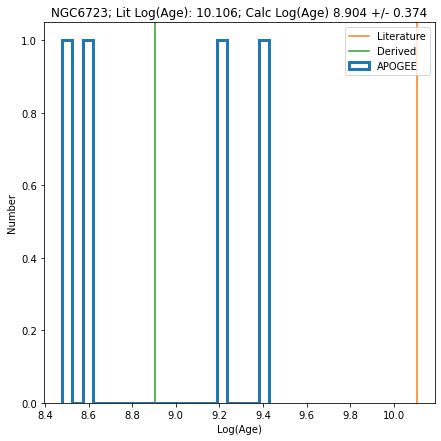

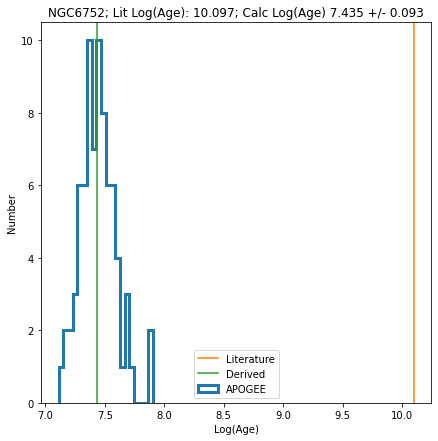

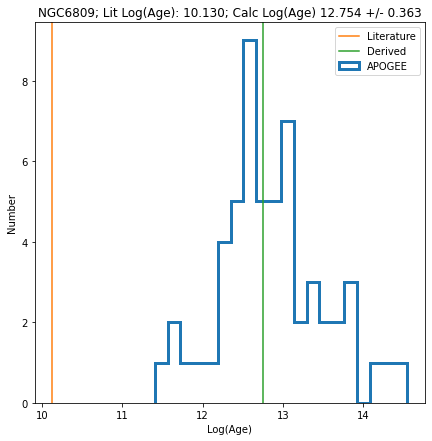

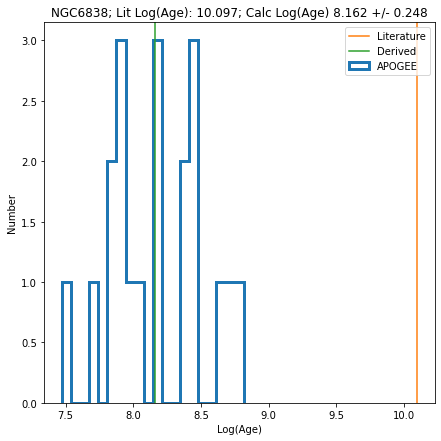

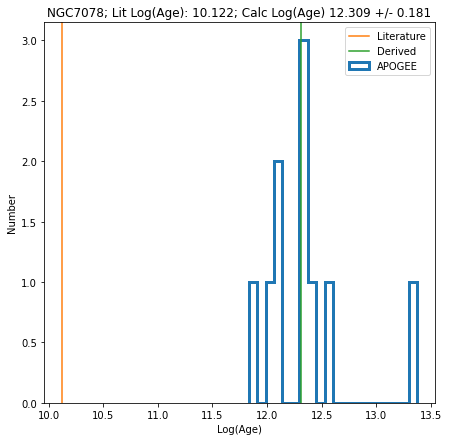

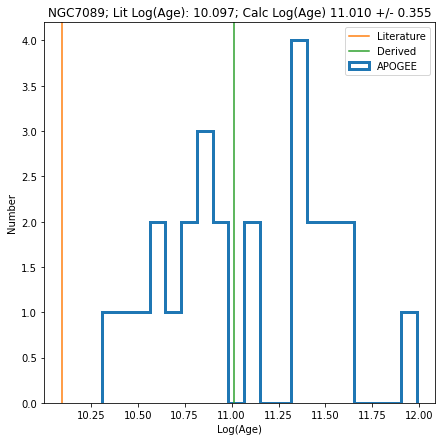

In [166]:
for i in range(len(np.squeeze(s2_ind))):
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    plt.figure(figsize=[7,7])
    plt.hist(parages_lit[clus],histtype='step',lw=3.0,bins=20,label='APOGEE')
    plt.axvline(np.log10(np.asarray(supp2['Age']*10**9)[s2_ind][i]),c='tab:orange',label='Literature')
    plt.axvline(np.median(parages_lit[clus]),c='tab:green',label='Derived')
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age']*10**9)[s2_ind][i]),
        np.median(parages_lit[clus]),afunc.mad(parages_lit[clus])))
    plt.xlabel(r'Log(Age)')
    plt.ylabel(r'Number')
    plt.show()

In [167]:
close_age_lit = []
close_feh_lit = []
for i in apogee_clus_idx:
    use_age = np.median(parages_lit[i])
    use_feh = np.median(afunc.sal(gcs['M_H'][i],gcs['ALPHA_M'][i]))
    
    close_age_lit.append(closest(use_age,parsec['logAge']))
    close_feh_lit.append(closest(use_feh,parsec['MH']))
    
supp2_close_age = []
for j in supp2['Age'][s2_ind]:
    supp2_close_age.append(closest(np.log10(j*(10**9)),parsec['logAge']))

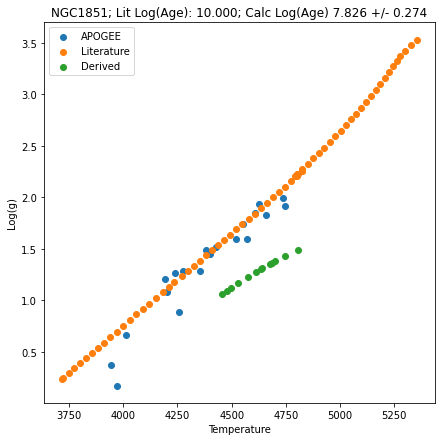

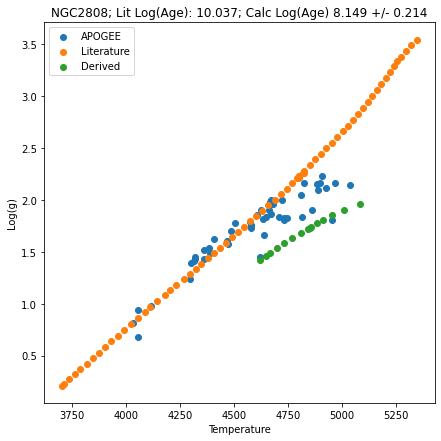

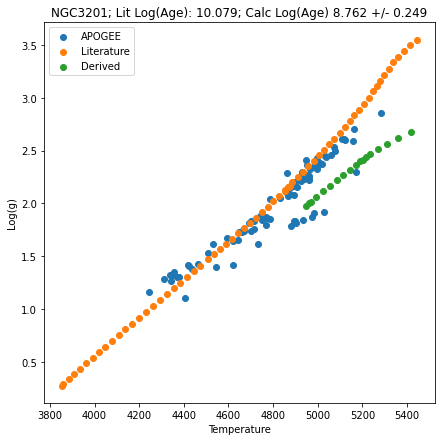

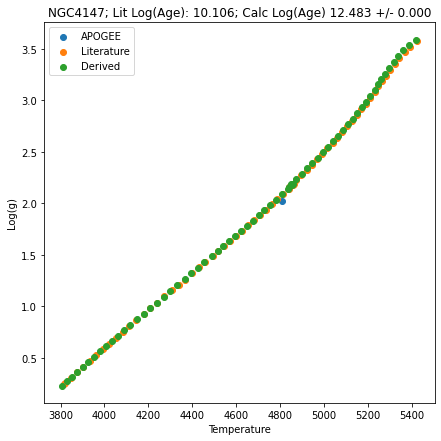

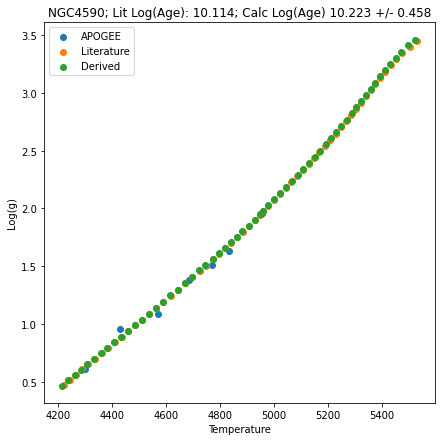

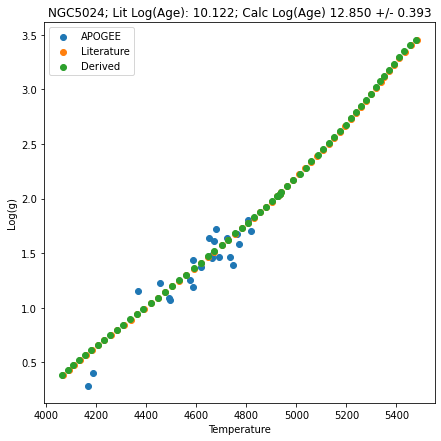

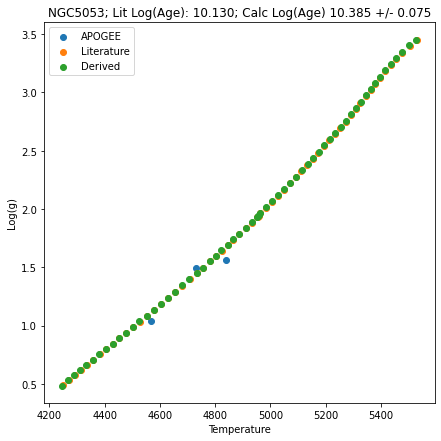

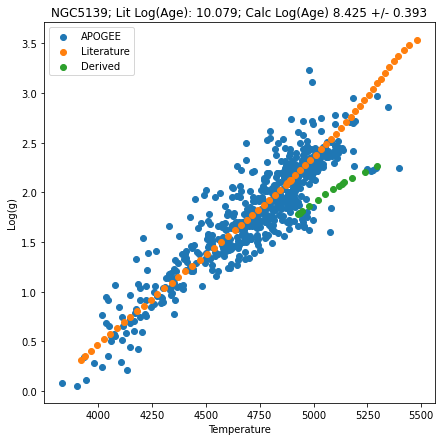

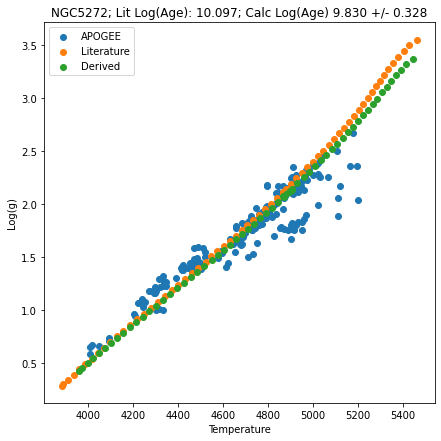

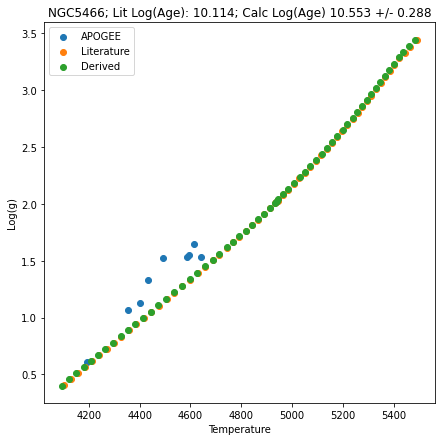

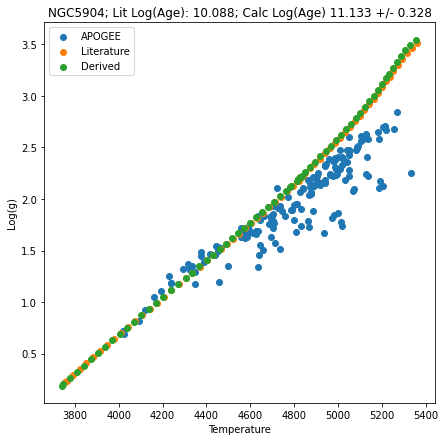

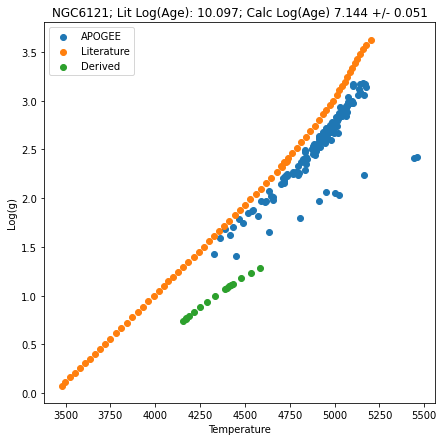

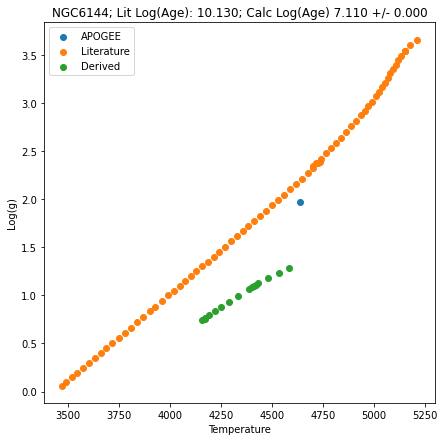

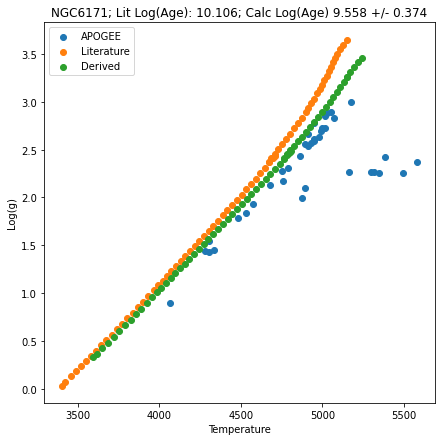

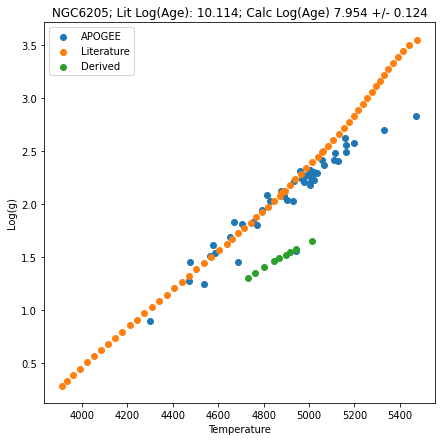

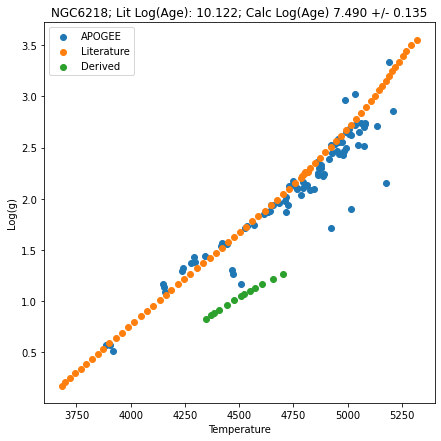

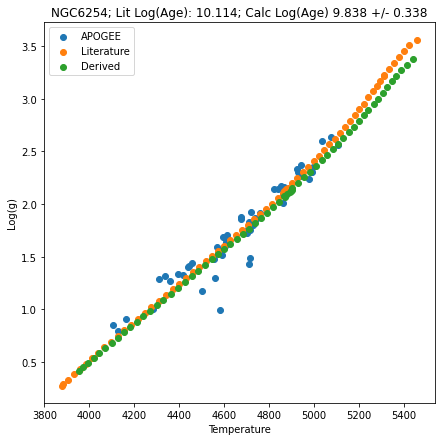

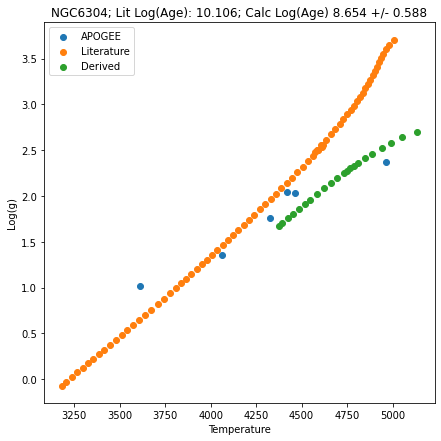

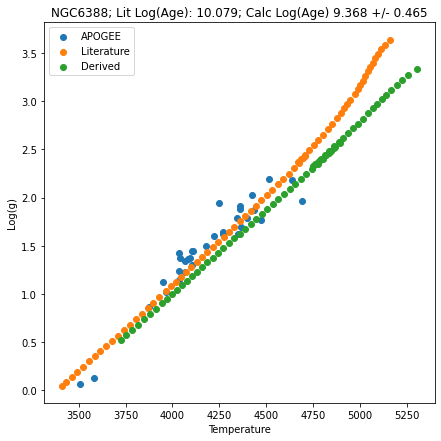

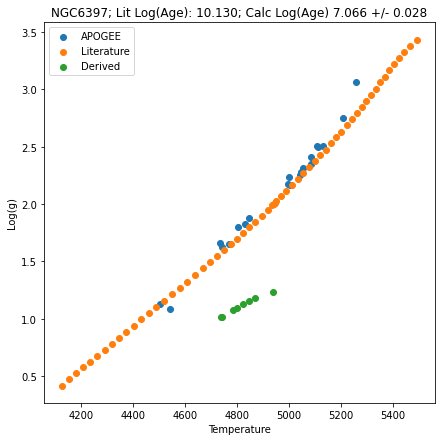

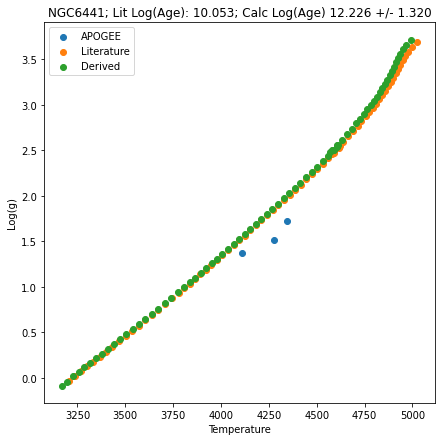

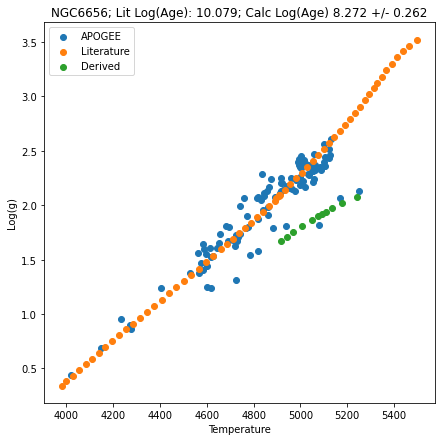

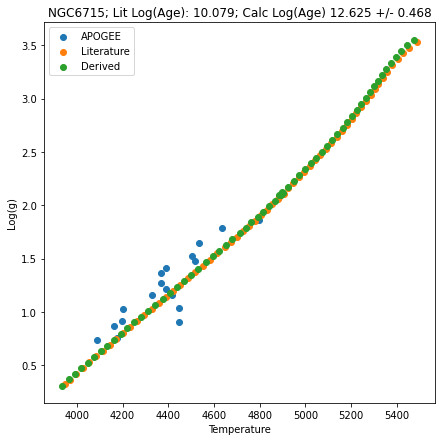

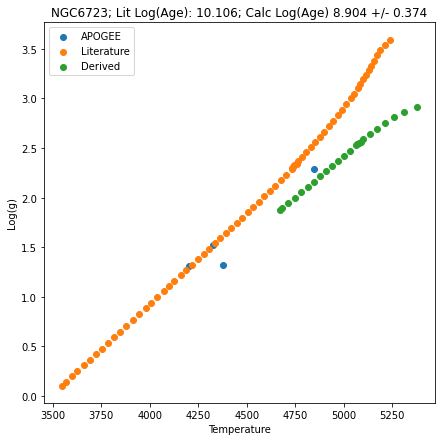

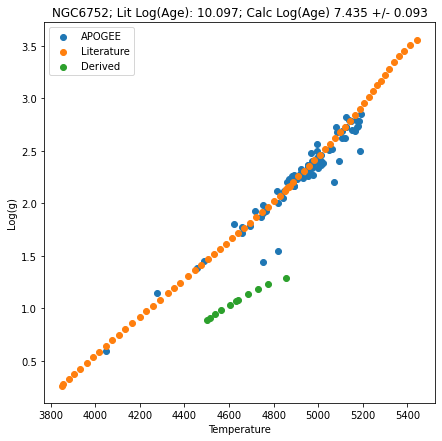

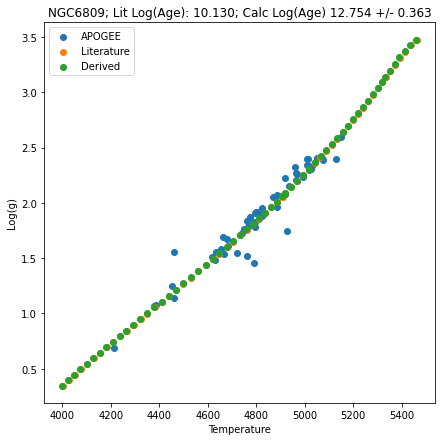

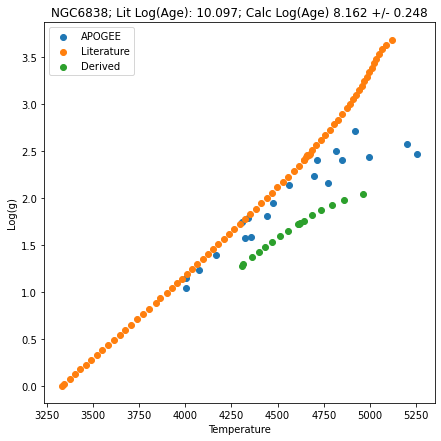

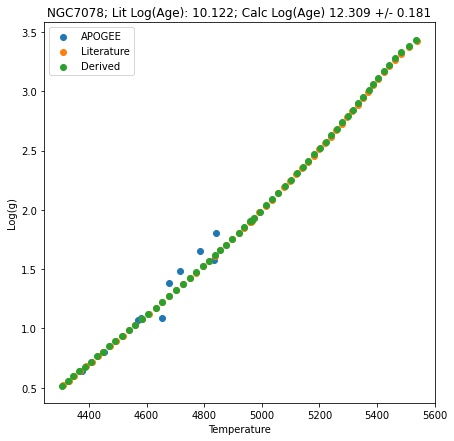

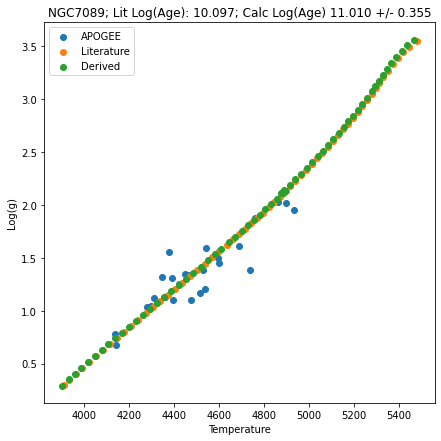

In [168]:
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh_lit[i]))
    pred = np.where((parsec['logAge']==close_age_lit[i])&(parsec['MH']==close_feh_lit[i]))
    
    plt.scatter(gcs['TEFF'][clus],gcs['LOGG'][clus],label='APOGEE')
    plt.scatter(10**parsec['logTe'][theo],parsec['logg'][theo],label='Literature')
    plt.scatter(10**parsec['logTe'][pred],parsec['logg'][pred],label='Derived')
    
    plt.legend()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age'])[s2_ind][i]*10**9),
        np.median(parages_lit[clus]),afunc.mad(parages_lit[clus])))
    
    plt.xlabel(r'Temperature')
    plt.ylabel(r'Log(g)')
    plt.show()

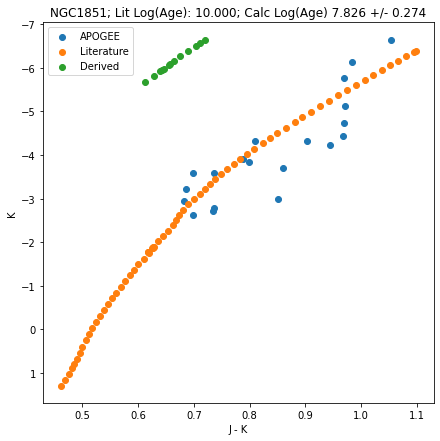

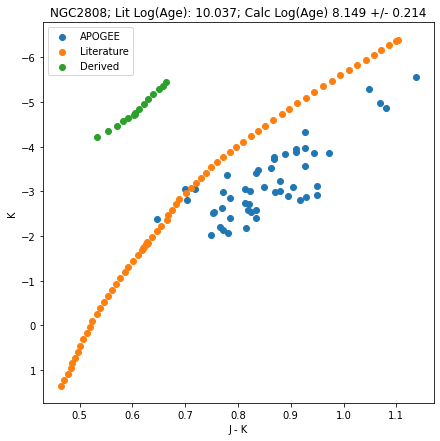

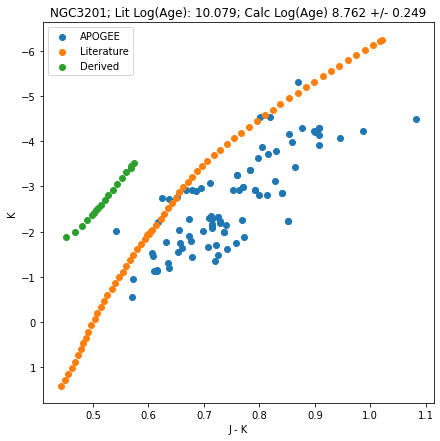

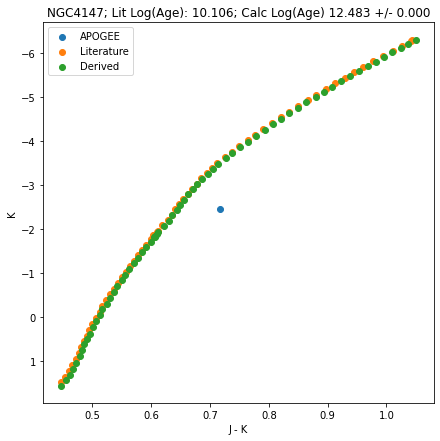

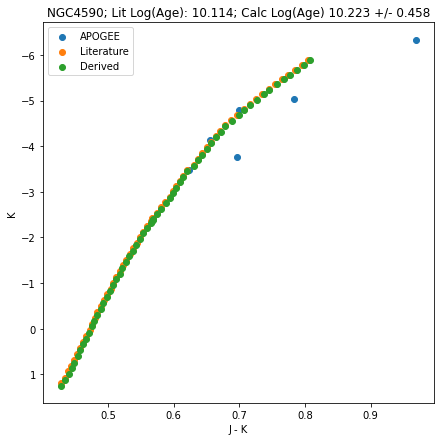

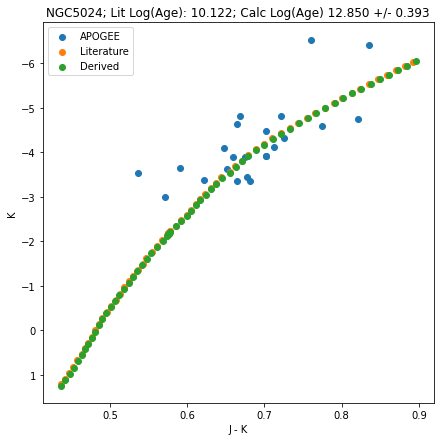

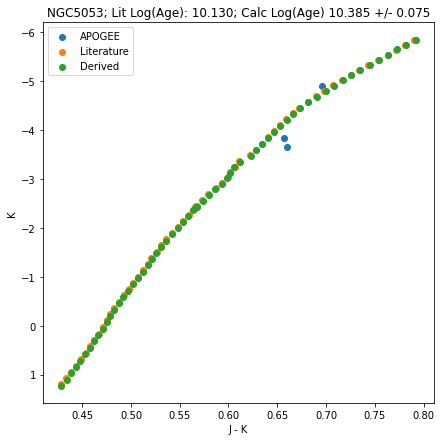

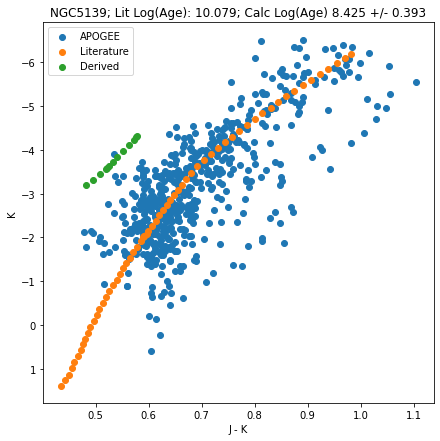

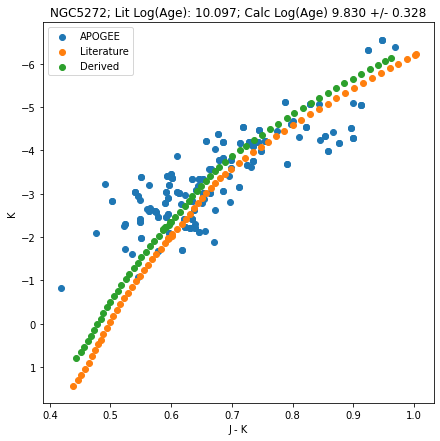

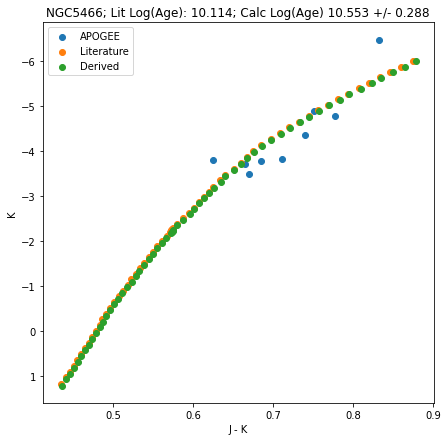

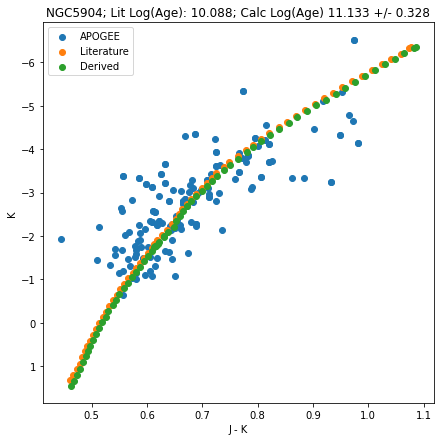

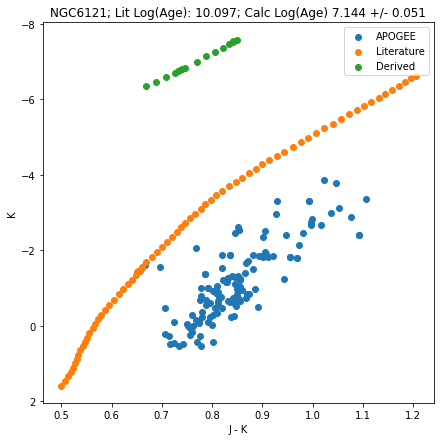

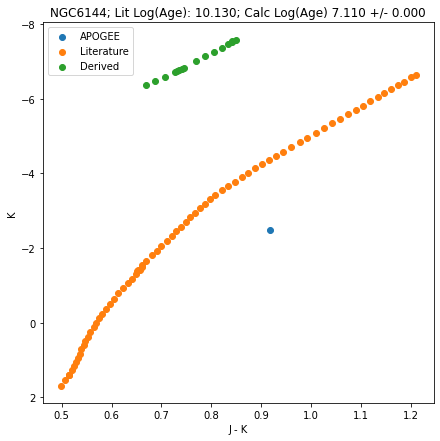

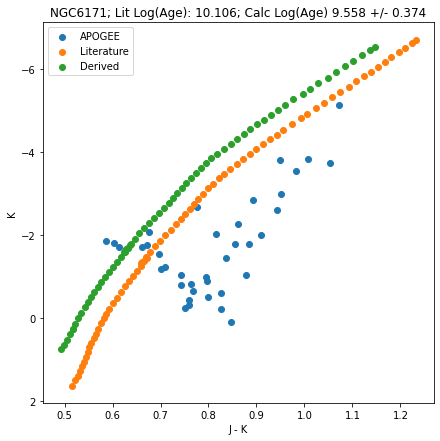

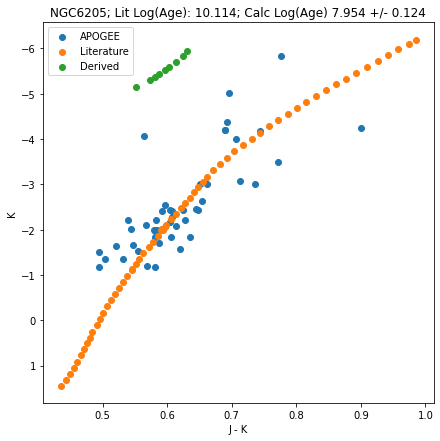

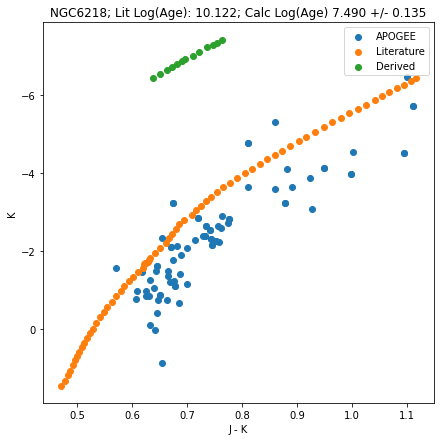

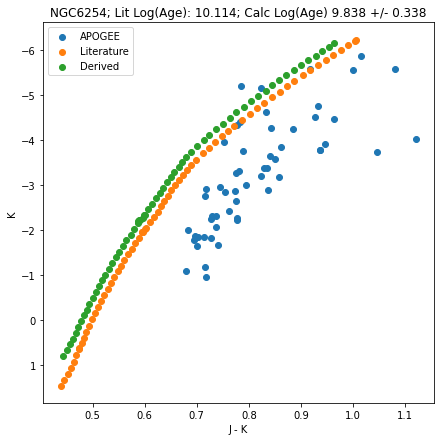

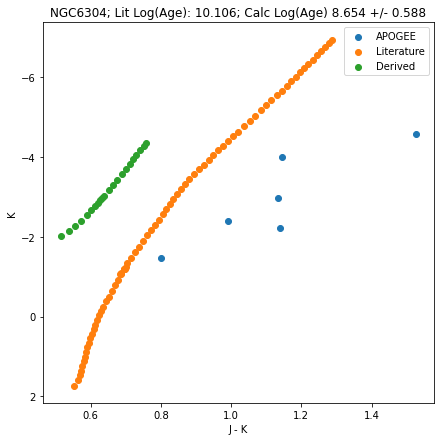

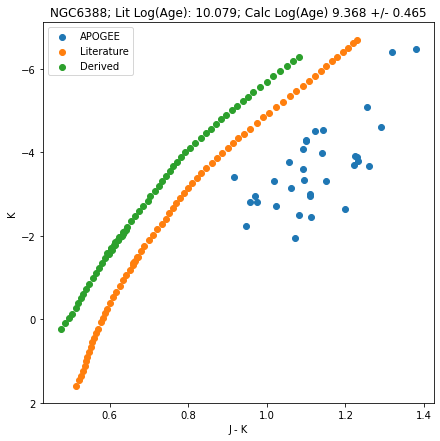

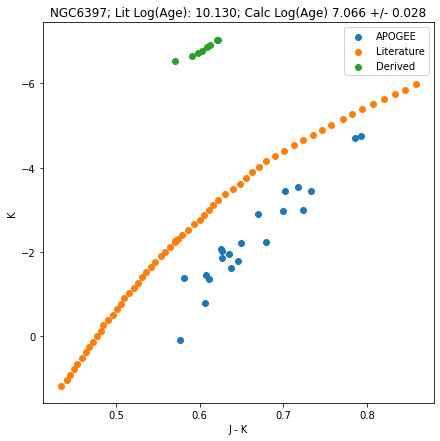

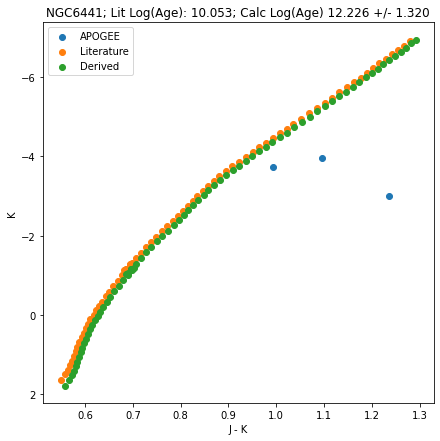

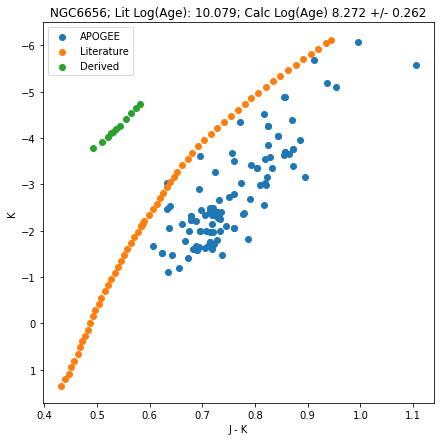

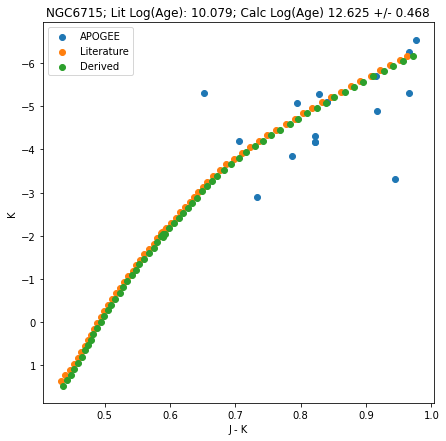

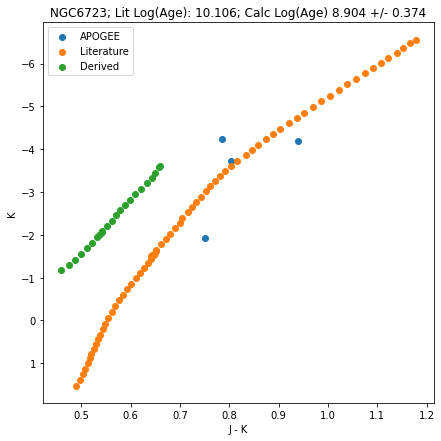

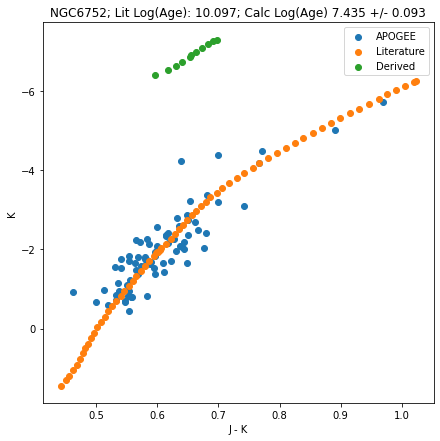

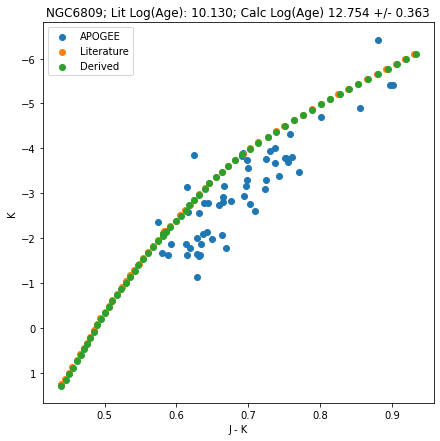

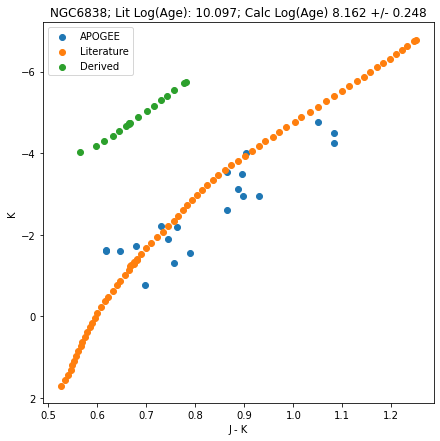

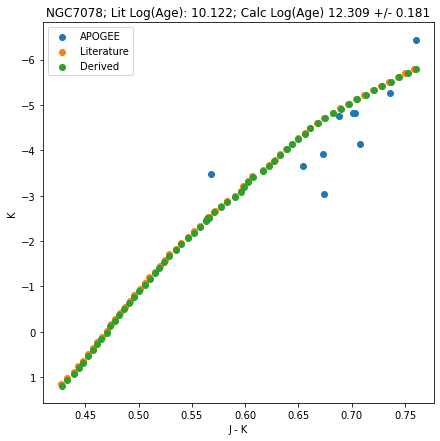

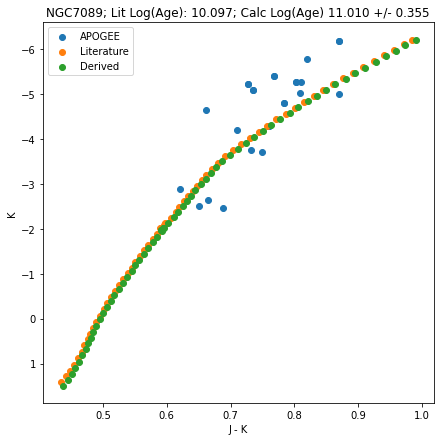

In [169]:
for i in range(len(np.squeeze(s2_ind))):
    plt.figure(figsize=[7,7])
    clus = np.where(ngc_names==np.asarray(supp2['Cluster'])[s2_ind][i])
    theo = np.where((parsec['logAge']==supp2_close_age[i])&(parsec['MH']==close_feh_lit[i]))
    pred = np.where((parsec['logAge']==close_age_lit[i])&(parsec['MH']==close_feh_lit[i]))
    
    plt.scatter((gcs['J']-gcs['K'])[clus],gcs_ksmag[clus],label='APOGEE')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[theo],parsec['Ksmag'][theo],label='Literature')
    plt.scatter((parsec['Jmag']-parsec['Ksmag'])[pred],parsec['Ksmag'][pred],label='Derived')
    
    plt.legend()
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}; Lit Log(Age): {:.3f}; Calc Log(Age) {:.3f} +/- {:.3f}'.format(
        np.asarray(supp2['Cluster'])[s2_ind][i],np.log10(np.asarray(supp2['Age'])[s2_ind][i]*10**9),
        np.median(parages_lit[clus]),afunc.mad(parages_lit[clus])))
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()